In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [3]:
BATCH_SIZE = 64

In [4]:
train_data =datasets.MNIST(root='data',train=True, download = True,transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train= False, download = True, transform=transforms.ToTensor())


train_subset, val_subset = torch.utils.data.random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=BATCH_SIZE)

100%|██████████| 9912422/9912422 [00:00<00:00, 110340693.44it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21004975.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40254776.67it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5831199.50it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### 1. Baseline Model

In [7]:
from torch.nn.modules.batchnorm import BatchNorm2d
class CNN(nn.Module):
  def __init__(self,batch_norm = True ):
    super(CNN, self).__init__()
    self.batch_norm = batch_norm

    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride =1, padding= 1)
    self.relu1 = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(32)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride =2)

    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride =1, padding= 1)
    self.relu2 = nn.ReLU()
    self.bn2 = nn.BatchNorm2d(32)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride =2)

    self.fc1 = nn.Linear(7*7*32, 500)
    self.fc2 = nn.Linear(500,10)


  def forward(self,x):
    x= self.conv1(x)
    x= self.relu1(x)
    if self.batch_norm:
      x=self.bn1(x)
    x= self.maxpool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    if self.batch_norm:
      x= self.bn2(x)
    x= self.maxpool2(x)

    x= x.view(-1,32*7*7)
    x= self.fc1(x)
    x= self.fc2(x)

    return F.log_softmax(x)








## **Without Batch Normalization**

In [8]:
#model without batch_norm
# learning_rate = 0.001
epochs = 10
batch_norm = False

model = CNN(batch_norm = batch_norm).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

train_cost, test_cost, accuracy = [],[],[]

for epoch in range(epochs):
  model.train()
  for i, (images,labels) in enumerate(train_loader):
    #get the data from cuda
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    #forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backward
    loss.backward()

    #gradient descent or adam step
    optimizer.step()

    if i%200 ==0 :
      model.eval()

      test_loss = 0
      num_correct = 0
      num_samples = 0



      with torch.no_grad():
        for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)
          test_loss += criterion(preds,labels).item()

          _,predictions = torch.max(preds.data,1)
          num_correct += (predictions == labels).sum()
          num_samples += predictions.size(0)

        # train_cost.append(loss.item())
        # accuracy.append(float(num_correct)/ num_samples)
        # test_cost.append(test_loss)


      test_loss /=len(test_loader)
      test_acc = float(num_correct)/ num_samples

      print('Epoch[{}/{}], Train loss: {:.4f}, Test loss: {:.4f}, Test Acc: {:.2f}%'
      .format(epoch+1, epochs, loss.item(), test_loss, test_acc*100))

      train_cost.append(loss.item())
      accuracy.append(float(num_correct)/ num_samples)
      test_cost.append(test_loss)
    # print('Epoch[{}/{}], Train loss: {:.4f}, Test loss: {:.4f}, Test Acc: {:.2f}%'
    #   .format(epoch+1, epochs, loss.item(), test_loss, test_acc*100))

    # best_model_path = 'best_model.pth'
torch.save(model.state_dict(), 'cnn_model.ckpt')
    # print(f"Best model saved to {best_model_path}")

<ipython-input-7-43bb7b7060d2>:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch[1/10], Train loss: 2.3124, Test loss: 2.3571, Test Acc: 10.32%
Epoch[1/10], Train loss: 0.1342, Test loss: 0.1197, Test Acc: 96.42%
Epoch[1/10], Train loss: 0.0858, Test loss: 0.0846, Test Acc: 97.35%
Epoch[1/10], Train loss: 0.0298, Test loss: 0.0688, Test Acc: 97.89%
Epoch[2/10], Train loss: 0.0176, Test loss: 0.0772, Test Acc: 97.44%
Epoch[2/10], Train loss: 0.0175, Test loss: 0.0458, Test Acc: 98.53%
Epoch[2/10], Train loss: 0.0207, Test loss: 0.0535, Test Acc: 98.17%
Epoch[2/10], Train loss: 0.0192, Test loss: 0.0434, Test Acc: 98.57%
Epoch[3/10], Train loss: 0.0017, Test loss: 0.0455, Test Acc: 98.48%
Epoch[3/10], Train loss: 0.0106, Test loss: 0.0411, Test Acc: 98.64%
Epoch[3/10], Train loss: 0.0020, Test loss: 0.0434, Test Acc: 98.55%
Epoch[3/10], Train loss: 0.0036, Test loss: 0.0473, Test Acc: 98.54%
Epoch[4/10], Train loss: 0.1441, Test loss: 0.0393, Test Acc: 98.59%
Epoch[4/10], Train loss: 0.0169, Test loss: 0.0440, Test Acc: 98.71%
Epoch[4/10], Train loss: 0.0342, T

#### Randomly selected test images

<ipython-input-7-43bb7b7060d2>:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


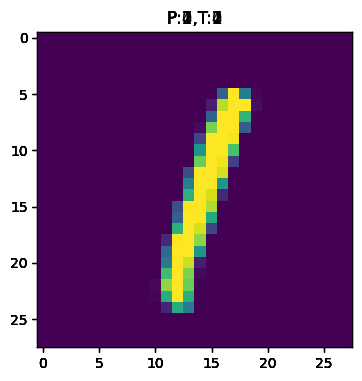

In [9]:
for img,label in test_loader:
  img = img.to(device)
  label = label.to(device)
  preds = model(img)
  fig = plt.figure(figsize=(18,9))
  fig.tight_layout()
  col,row = 3,2
  y_preds = torch.max(preds.data,1)[1].cpu().numpy()
  for i in range(1, col*row+1):
    a= fig.add_subplot(row,col,1)
    a.set_title('P:{},T:{}'.format(y_preds[i-1],label.data[i-1]))
    plt.imshow(img[i-1,0].cpu().numpy())

  plt.show()
  break


#### Plots for training error, validation error and prediction accuracy

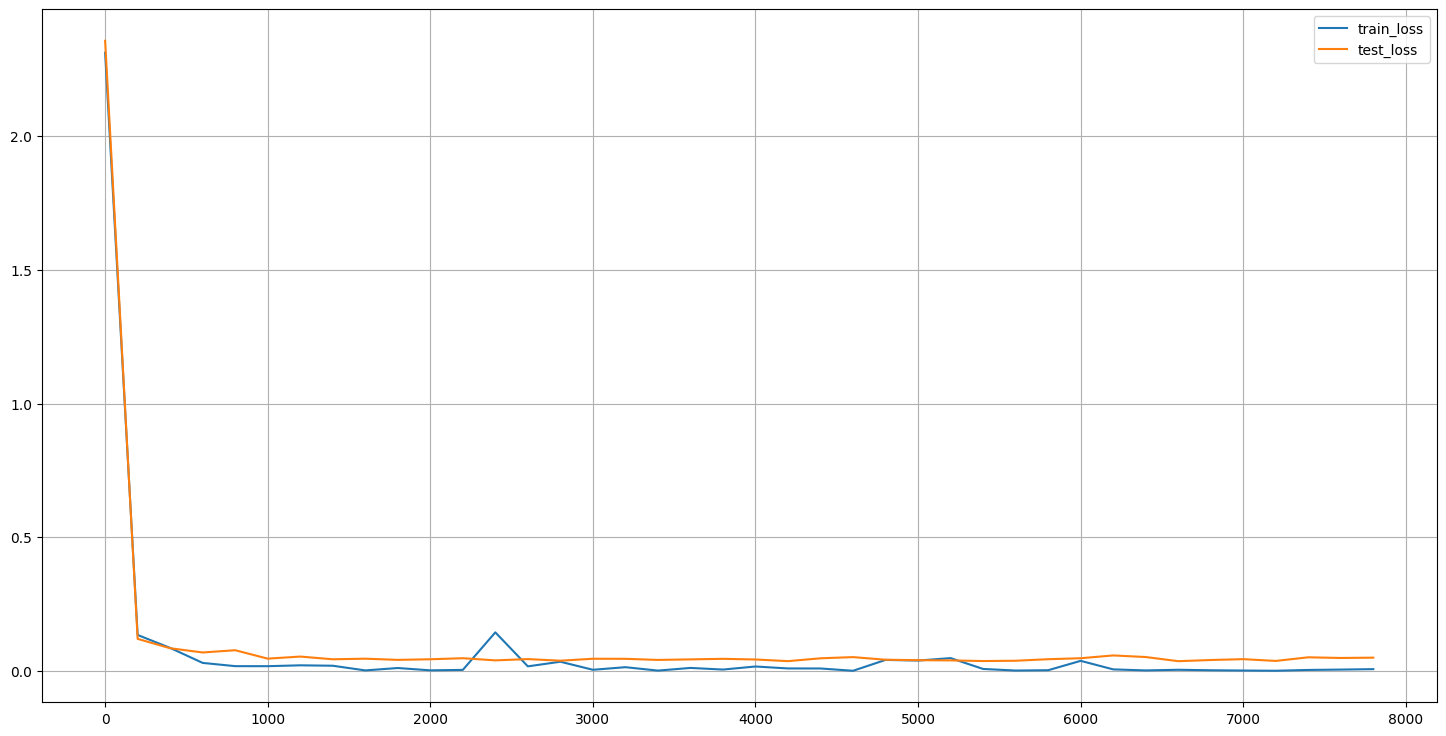

In [10]:
x = 200*np.arange(len(train_cost))
plt.figure(figsize=(18,9))
plt.plot(x,train_cost,label ='train_loss')
plt.plot(x,test_cost,label='test_loss')
plt.legend()
plt.grid()
plt.show()

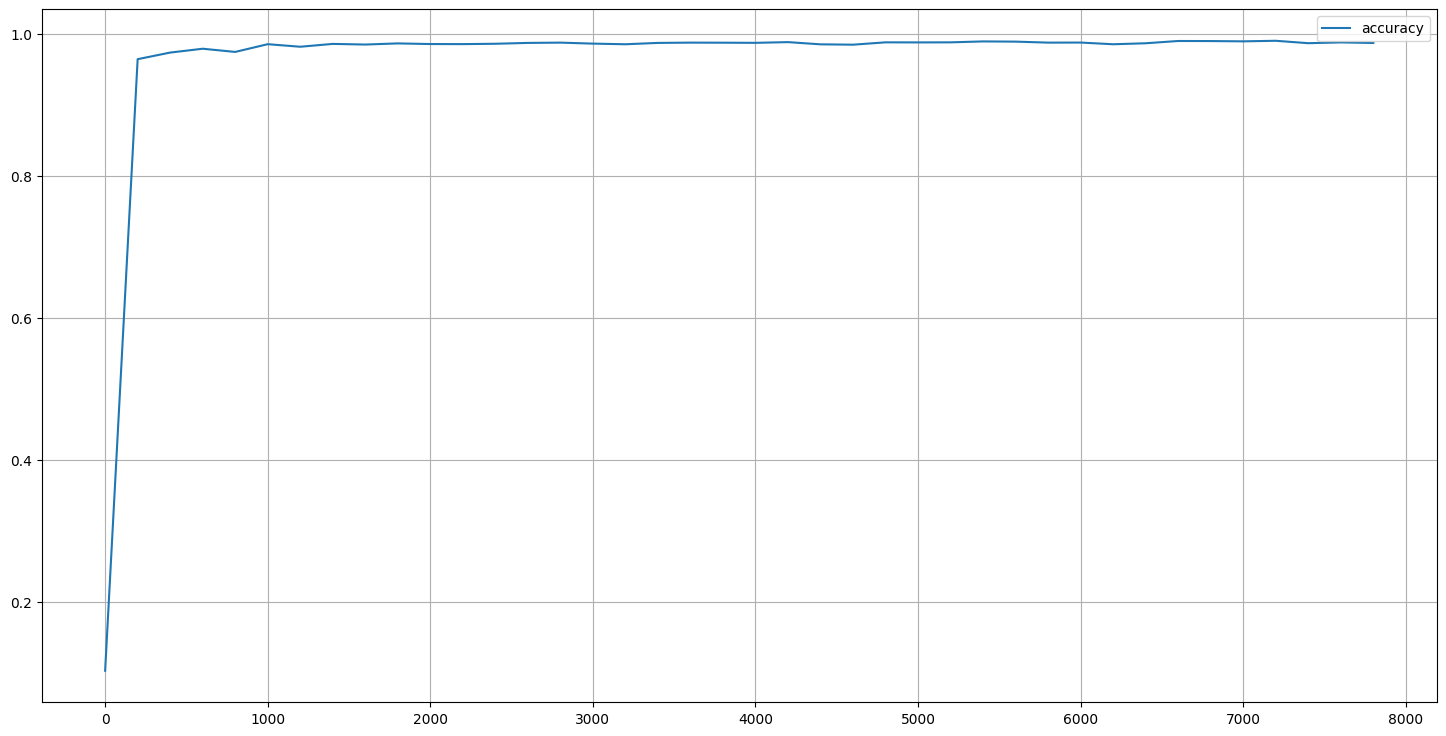

In [11]:
x = 200*np.arange(len(accuracy))
plt.figure(figsize=(18,9))
plt.plot(x,accuracy,label ='accuracy')
# plt.plot(x,test_cost,label='test_loss')
plt.legend()
plt.grid()
plt.show()

## **Using Batch Normalization**


In [12]:
# learning_rate = 0.001
epochs = 10
batch_norm = True

model = CNN(batch_norm = batch_norm).to(device)
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

train_cost_bn, test_cost_bn, accuracy_bn = [],[],[]

for epoch in range(epochs):
  model.train()
  for i, (images,labels) in enumerate(train_loader):
    #get the data from cuda
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    #forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backward
    loss.backward()

    #gradient descent or adam step
    optimizer.step()

    if i%200 ==0 :
      model.eval()

      test_loss = 0
      num_correct = 0
      num_samples = 0



      with torch.no_grad():
        for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)
          test_loss += criterion(preds,labels).item()

          _,predictions = torch.max(preds.data,1)
          num_correct += (predictions == labels).sum()
          num_samples += predictions.size(0)

        # train_cost.append(loss.item())
        # accuracy.append(float(num_correct)/ num_samples)
        # test_cost.append(test_loss)


      test_loss /=len(test_loader)
      test_acc = float(num_correct)/ num_samples

      print('Epoch[{}/{}], Train loss: {:.4f}, Test loss: {:.4f}, Test Acc: {:.2f}%'
      .format(epoch+1, epochs, loss.item(), test_loss, test_acc*100))

      train_cost_bn.append(loss.item())
      accuracy_bn.append(float(num_correct)/ num_samples)
      test_cost_bn.append(test_loss)
    # print('Epoch[{}/{}], Train loss: {:.4f}, Test loss: {:.4f}, Test Acc: {:.2f}%'
    #   .format(epoch+1, epochs, loss.item(), test_loss, test_acc*100))

    # best_model_path = 'best_model.pth'
torch.save(model.state_dict(), 'cnn_model_batch_norm.ckpt')
    # print(f"Best model saved to {best_model_path}")

<ipython-input-7-43bb7b7060d2>:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch[1/10], Train loss: 2.2708, Test loss: 2.2636, Test Acc: 27.62%
Epoch[1/10], Train loss: 0.0369, Test loss: 0.1163, Test Acc: 96.51%
Epoch[1/10], Train loss: 0.0478, Test loss: 0.0732, Test Acc: 97.68%
Epoch[1/10], Train loss: 0.0984, Test loss: 0.0617, Test Acc: 97.98%
Epoch[2/10], Train loss: 0.2670, Test loss: 0.0739, Test Acc: 97.42%
Epoch[2/10], Train loss: 0.0341, Test loss: 0.0567, Test Acc: 98.15%
Epoch[2/10], Train loss: 0.1067, Test loss: 0.0502, Test Acc: 98.18%
Epoch[2/10], Train loss: 0.1350, Test loss: 0.0482, Test Acc: 98.34%
Epoch[3/10], Train loss: 0.0078, Test loss: 0.0519, Test Acc: 98.32%
Epoch[3/10], Train loss: 0.0753, Test loss: 0.0440, Test Acc: 98.50%
Epoch[3/10], Train loss: 0.0428, Test loss: 0.0372, Test Acc: 98.68%
Epoch[3/10], Train loss: 0.0250, Test loss: 0.0425, Test Acc: 98.63%
Epoch[4/10], Train loss: 0.1041, Test loss: 0.0451, Test Acc: 98.62%
Epoch[4/10], Train loss: 0.0388, Test loss: 0.0421, Test Acc: 98.64%
Epoch[4/10], Train loss: 0.1469, T

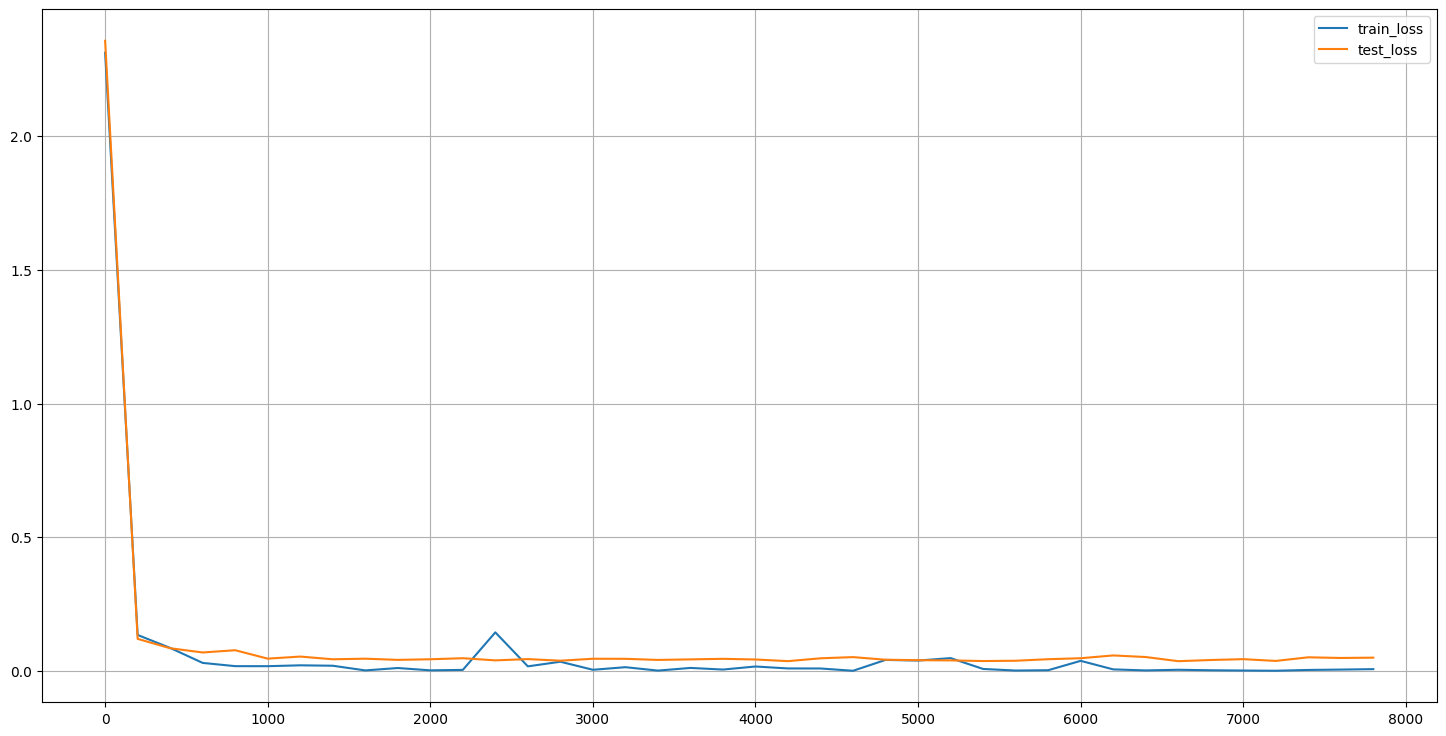

In [13]:

x = 200*np.arange(len(train_cost))
plt.figure(figsize=(18,9))
plt.plot(x,train_cost,label ='train_loss')
plt.plot(x,test_cost,label='test_loss')
plt.legend()
plt.grid()
plt.show()

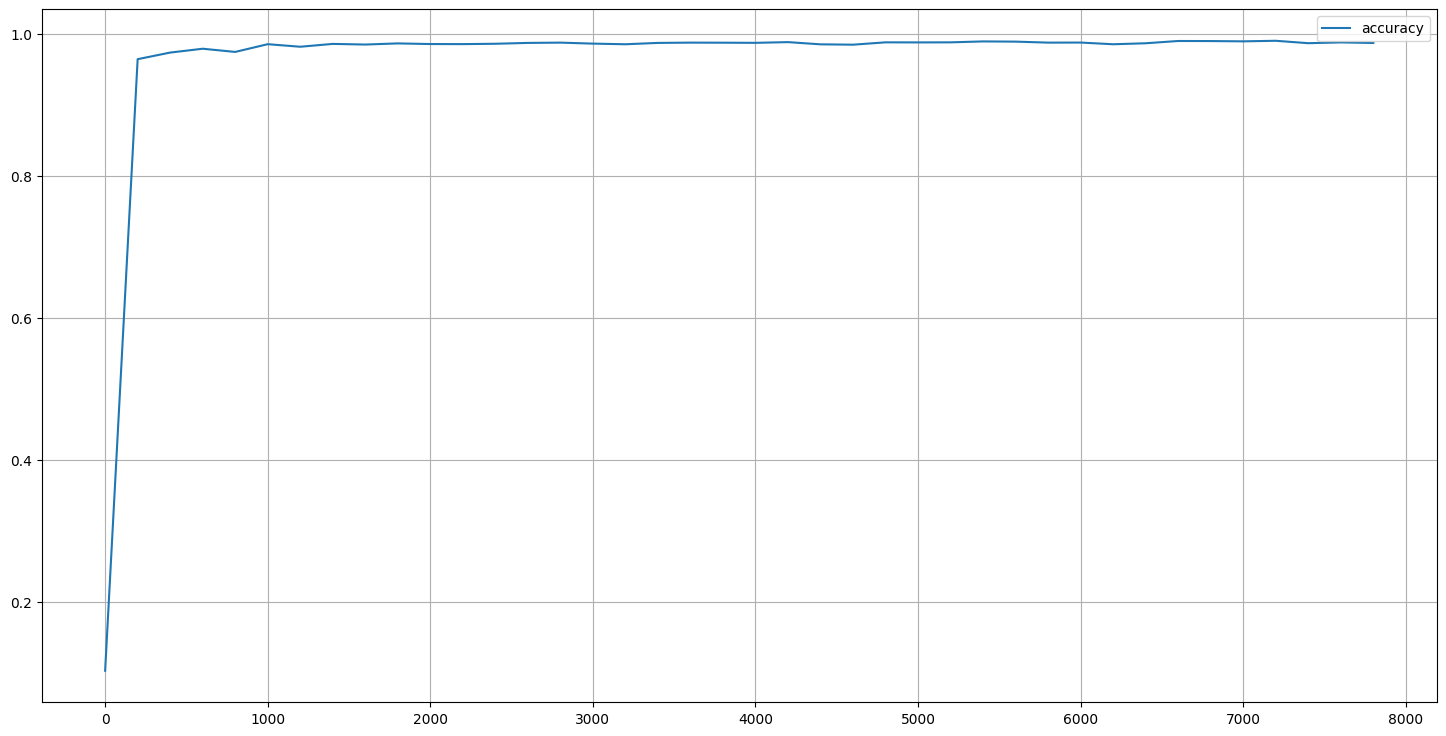

In [14]:
x = 200*np.arange(len(accuracy))
plt.figure(figsize=(18,9))
plt.plot(x,accuracy,label ='accuracy')
# plt.plot(x,test_cost,label='test_loss')
plt.legend()
plt.grid()
plt.show()

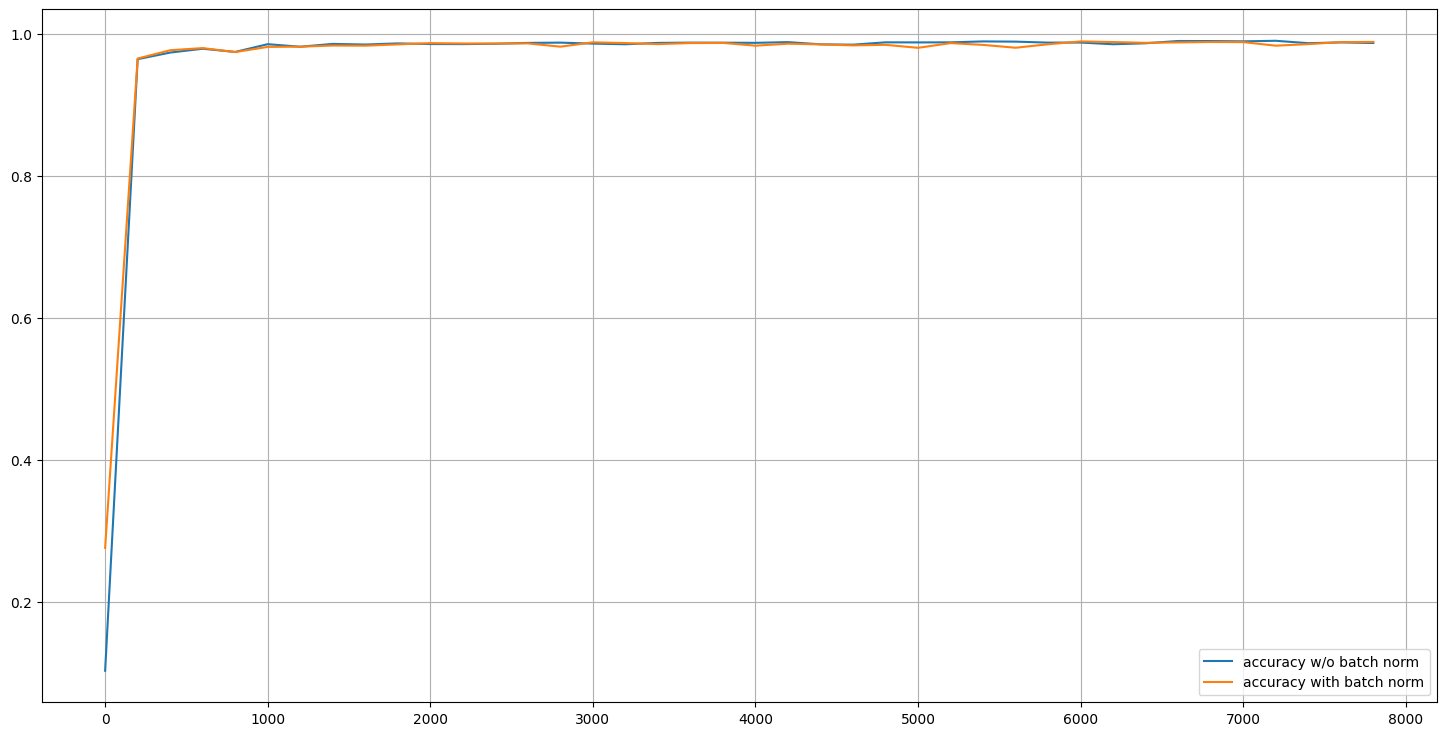

In [15]:
x = 200*np.arange(len(accuracy))
plt.figure(figsize=(18,9))
plt.plot(x,accuracy,label ='accuracy w/o batch norm')
plt.plot(x,accuracy_bn,label='accuracy with batch norm')
plt.legend()
plt.grid()
plt.show()

The accuracy with batch normalization and without are relatively same.

### Dimension of input and output of each layer

In [16]:
checkpoint = torch.load('cnn_model.ckpt')
model = CNN().to(device)

from torchsummary import summary
summary(model, (1,28,28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           9,248
              ReLU-6           [-1, 32, 14, 14]               0
       BatchNorm2d-7           [-1, 32, 14, 14]              64
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Linear-9                  [-1, 500]         784,500
           Linear-10                   [-1, 10]           5,010
Total params: 799,206
Trainable params: 799,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 3.05
Estimated T

<ipython-input-7-43bb7b7060d2>:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Number of neurons :
*   conv1 : 28x28x32
*   conv2 : 32x14x14
*   fc1 :500
*   fc2 : 10

In [17]:
#parametrs and torch size without using summary

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters:{total_params}")


model.load_state_dict(checkpoint)
model.eval()
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Total number of parameters:799206
conv1.weight 	 torch.Size([32, 1, 3, 3])
conv1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([32, 32, 3, 3])
conv2.bias 	 torch.Size([32])
bn2.weight 	 torch.Size([32])
bn2.bias 	 torch.Size([32])
bn2.running_mean 	 torch.Size([32])
bn2.running_var 	 torch.Size([32])
bn2.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([500, 1568])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])


## 2. Visualizing the Convolutional Neural Network

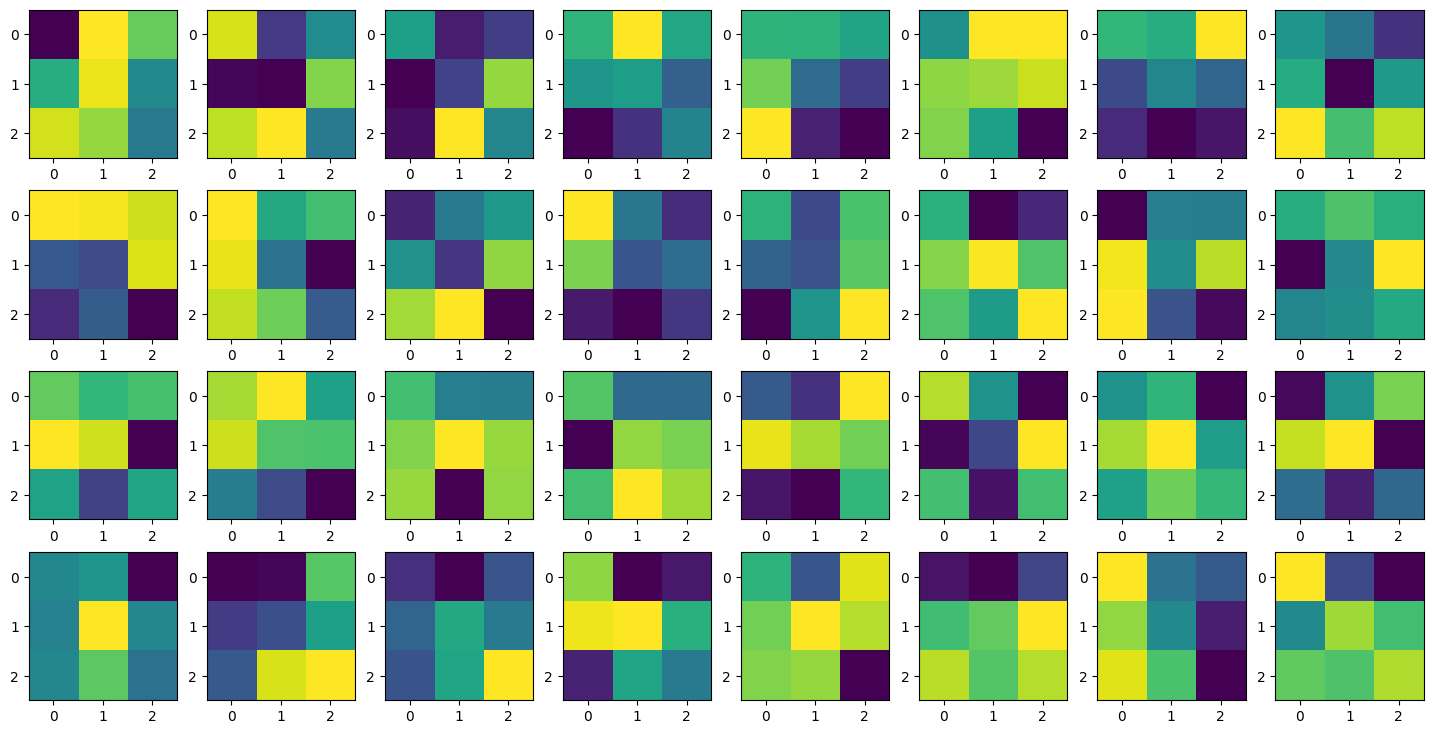

In [18]:
#plotting the conv1 layer filters

def normalize(x):
  out = np.zeros_like(x)
  for i in range(x.shape[0]):
    max,min = np.amax(x[i]), np.amin(x[i])
    out[i] = (x[i]-min)/(max- min + 0.00001)
  return out

conv1_layer = model.state_dict()['conv1.weight'].cpu().numpy()
conv2_layer = model.state_dict()['conv2.weight'].cpu().numpy()


conv1_norm = normalize(conv1_layer)
conv2_norm = normalize(conv2_layer)
conv1_norm = conv1_norm.reshape(32,3,3)

fig =plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row, col,i)
  plt.imshow((conv1_norm[i-1]*255).astype(np.uint8))

plt.show()

The filter has different patterns

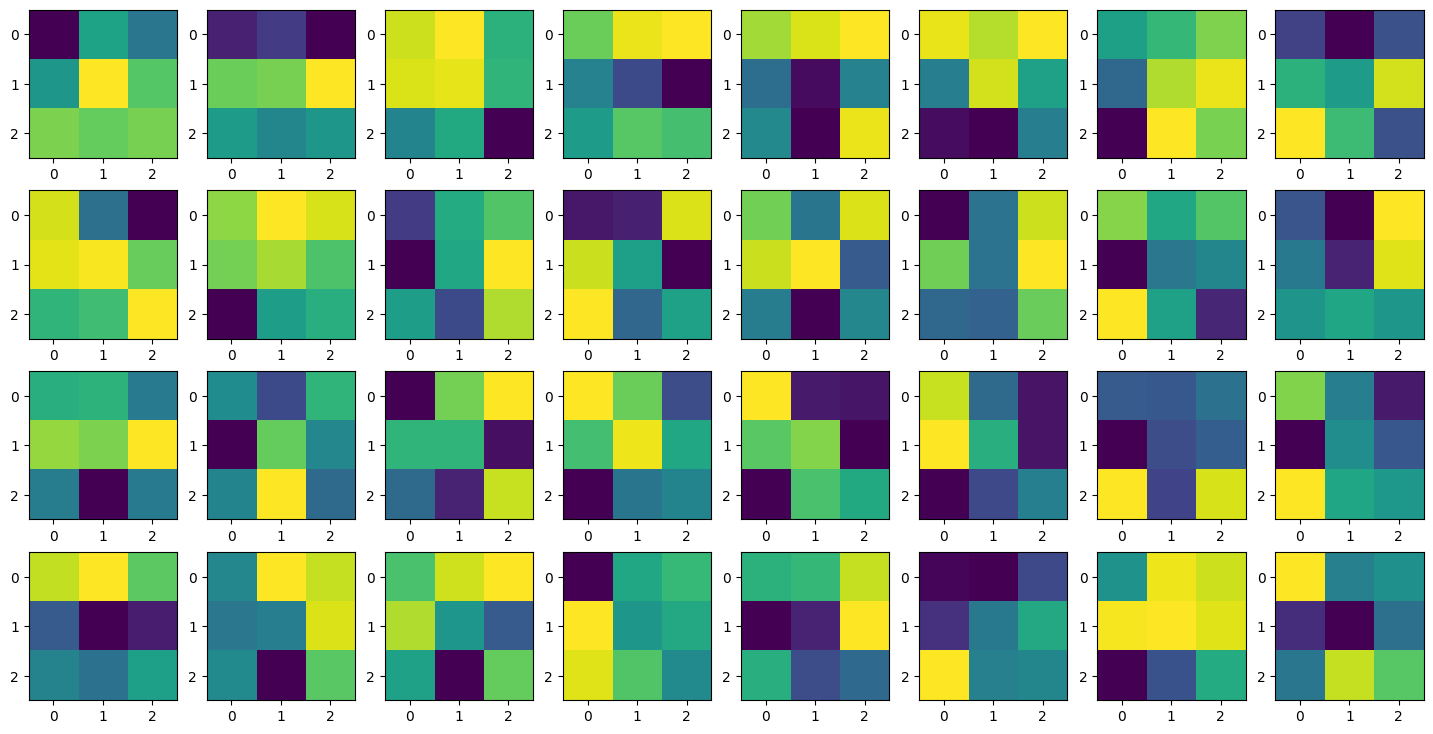

In [19]:
#plotting conv layer2 filters
conv2_layer = model.state_dict()['conv2.weight'].cpu().numpy()
conv2_norm = normalize(conv2_layer)

fig =plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row, col,i)
  plt.imshow((conv2_norm[i-1,7]*255).astype(np.uint8))

plt.show()

In [20]:
visualize_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=1,shuffle=False)


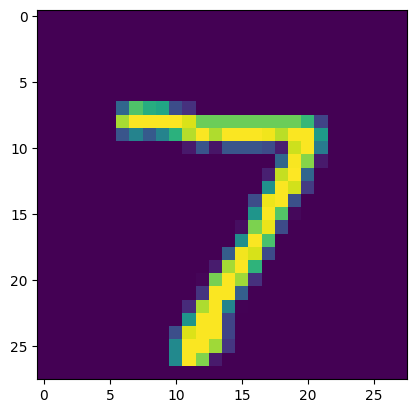

conv1 output shape: (32, 28, 28)
conv1 output shape: (32, 14, 14)
conv2 output shape: (32, 14, 14)


In [25]:

for images,labels in visualize_loader:
  images = images.to(device)
  labels = labels.to(device)
  img = images.cpu().numpy().reshape(28,28)
  plt.imshow(img)
  plt.show()

  conv1_out = model.conv1(images)
  conv1_out_np = conv1_out.cpu().detach().numpy().reshape(32,28,28)
  print('conv1 output shape:',conv1_out_np.shape)

  max1_out = model.maxpool1(conv1_out)
  max1_out_np = max1_out.cpu().detach().numpy().reshape(32,14,14)
  print('conv1 output shape:',max1_out_np.shape)


  conv2_out = model.conv2(max1_out)
  conv2_out_np = conv2_out.cpu().detach().numpy().reshape(32,14,14)
  print('conv2 output shape:',conv2_out_np.shape)

  break

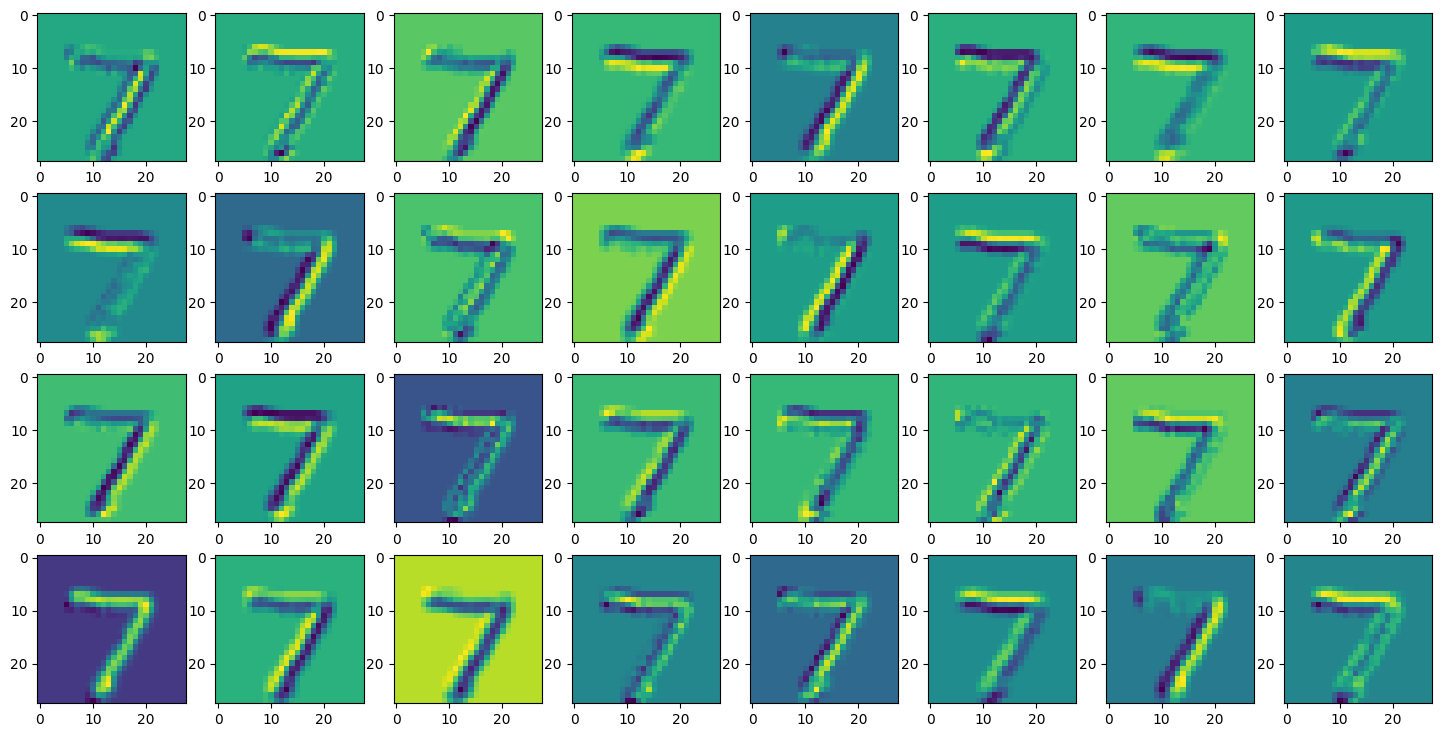

In [26]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv1_out_np[i-1])

plt.show()

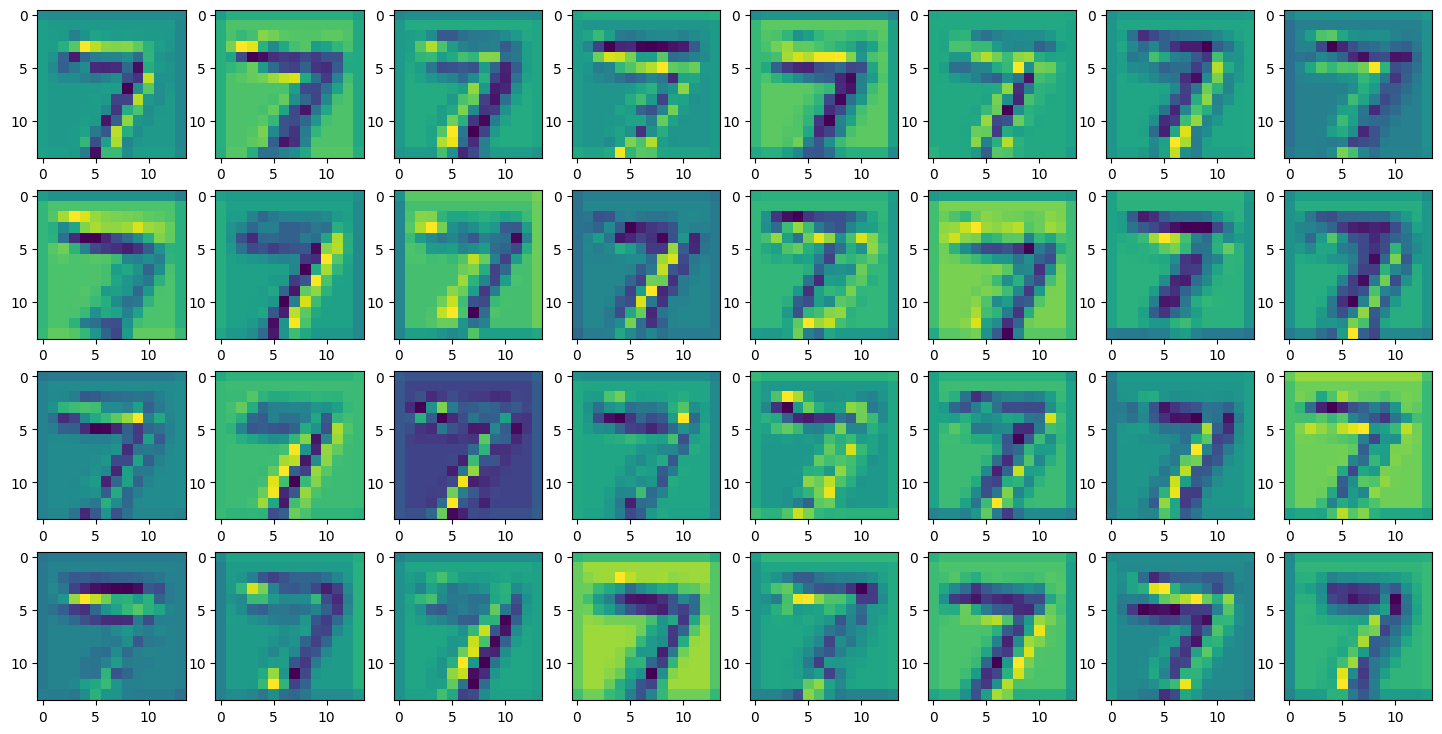

In [29]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(conv2_out_np[i-1])

plt.show()


As the layer gets deeper, the activation layer becomes more blur.

## Occluding parts of the image

In [30]:
def occluded_image(x,i,j,patch_size=14):
  """
   We propose to use 16 7x7 grey patches to occlude. So, total 16 images will be generated.
  """
  y = x.copy()
  y[i:i+patch_size,j:j+patch_size] = 0.5
  return y


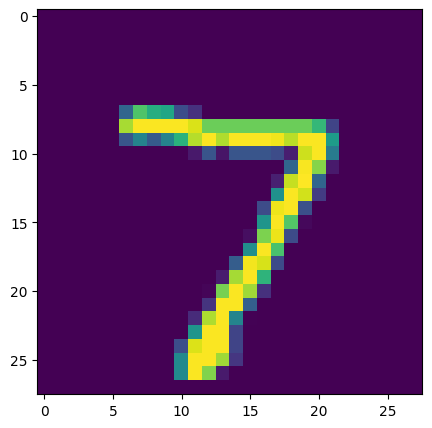

<ipython-input-7-43bb7b7060d2>:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Figure:1, Actual Class:7, Probability:1.0000, Predicted:7
Figure:2, Actual Class:7, Probability:0.9992, Predicted:7
Figure:3, Actual Class:7, Probability:1.0000, Predicted:7
Figure:4, Actual Class:7, Probability:1.0000, Predicted:7
Figure:5, Actual Class:7, Probability:0.6954, Predicted:7
Figure:6, Actual Class:7, Probability:1.0000, Predicted:7
Figure:7, Actual Class:7, Probability:1.0000, Predicted:7
Figure:8, Actual Class:7, Probability:1.0000, Predicted:7
Figure:9, Actual Class:7, Probability:1.0000, Predicted:7


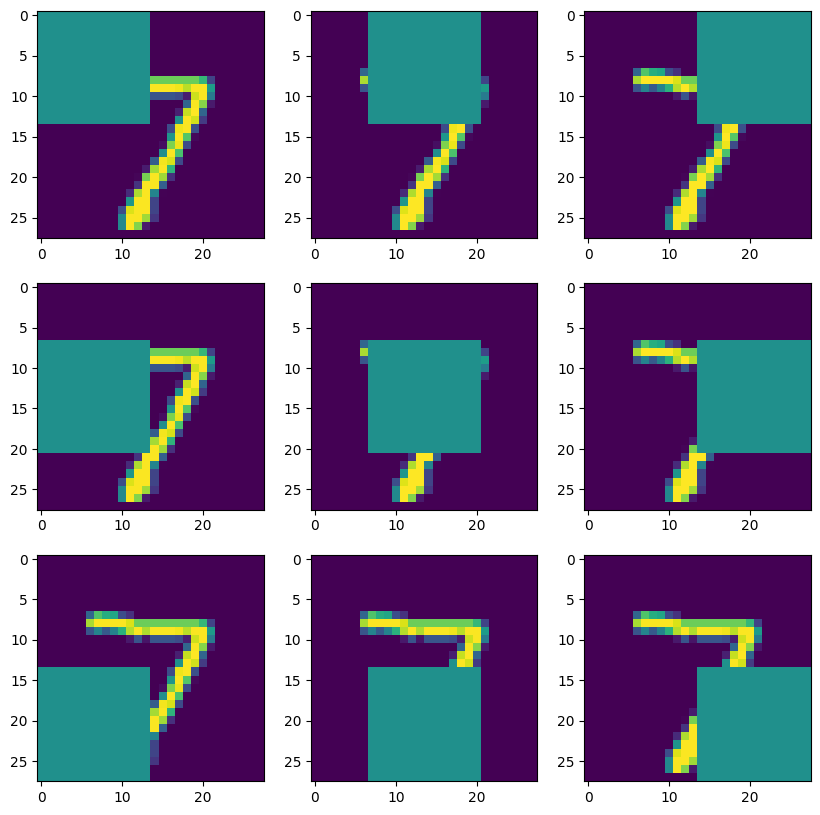

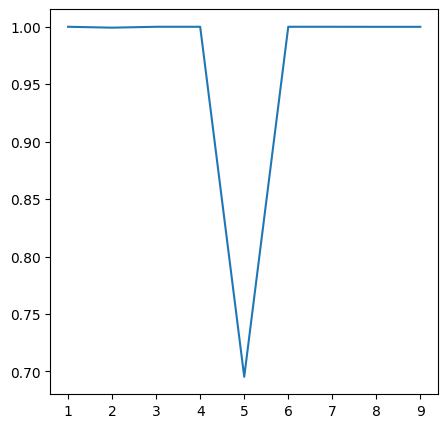

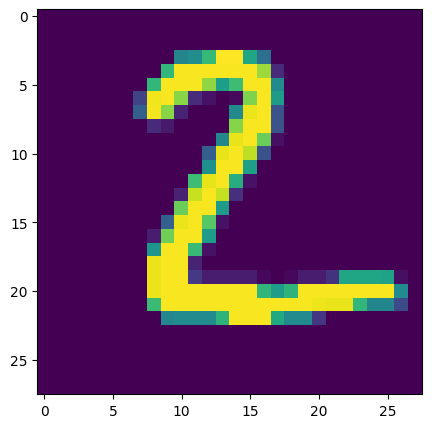

Figure:1, Actual Class:2, Probability:1.0000, Predicted:2
Figure:2, Actual Class:2, Probability:1.0000, Predicted:2
Figure:3, Actual Class:2, Probability:1.0000, Predicted:2
Figure:4, Actual Class:2, Probability:1.0000, Predicted:2
Figure:5, Actual Class:2, Probability:1.0000, Predicted:2
Figure:6, Actual Class:2, Probability:1.0000, Predicted:2
Figure:7, Actual Class:2, Probability:1.0000, Predicted:2
Figure:8, Actual Class:2, Probability:1.0000, Predicted:2
Figure:9, Actual Class:2, Probability:0.9866, Predicted:2


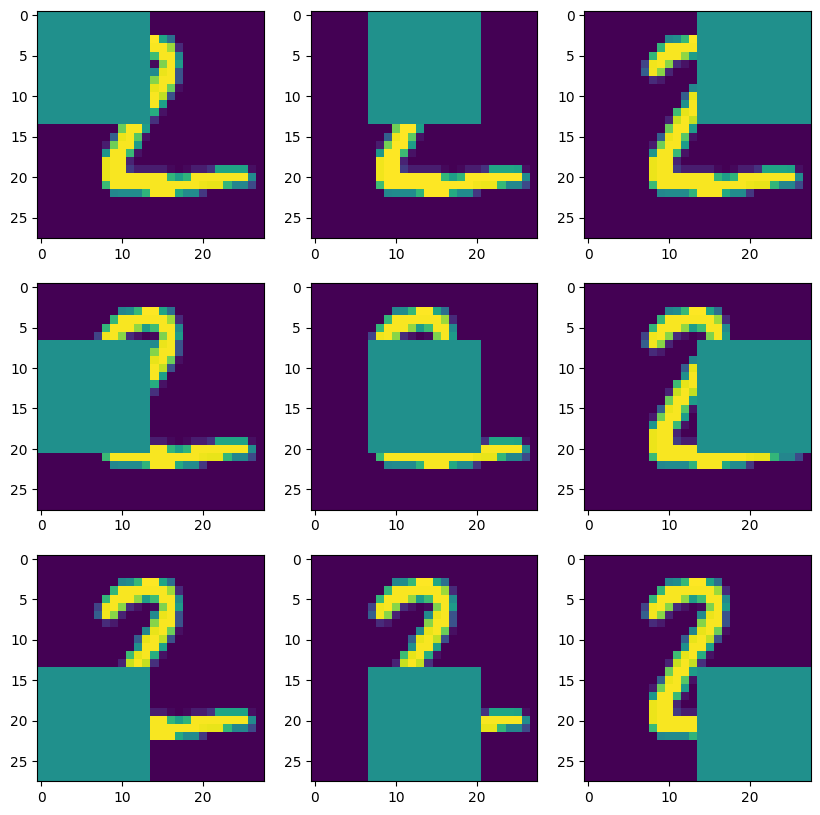

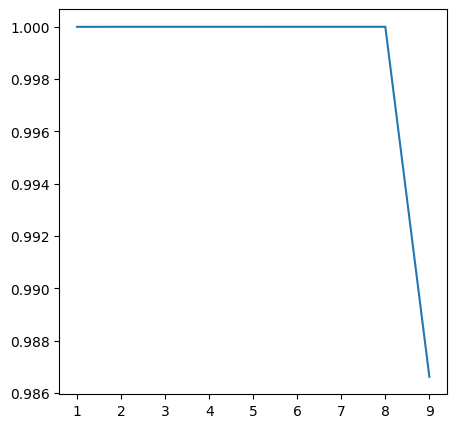

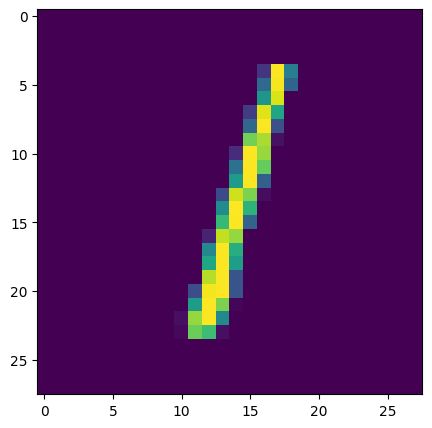

Figure:1, Actual Class:1, Probability:0.9346, Predicted:1
Figure:2, Actual Class:1, Probability:0.0707, Predicted:8
Figure:3, Actual Class:1, Probability:0.7554, Predicted:1
Figure:4, Actual Class:1, Probability:0.9968, Predicted:1
Figure:5, Actual Class:1, Probability:0.1303, Predicted:4
Figure:6, Actual Class:1, Probability:0.9920, Predicted:1
Figure:7, Actual Class:1, Probability:0.9981, Predicted:1
Figure:8, Actual Class:1, Probability:0.3140, Predicted:4
Figure:9, Actual Class:1, Probability:0.9881, Predicted:1


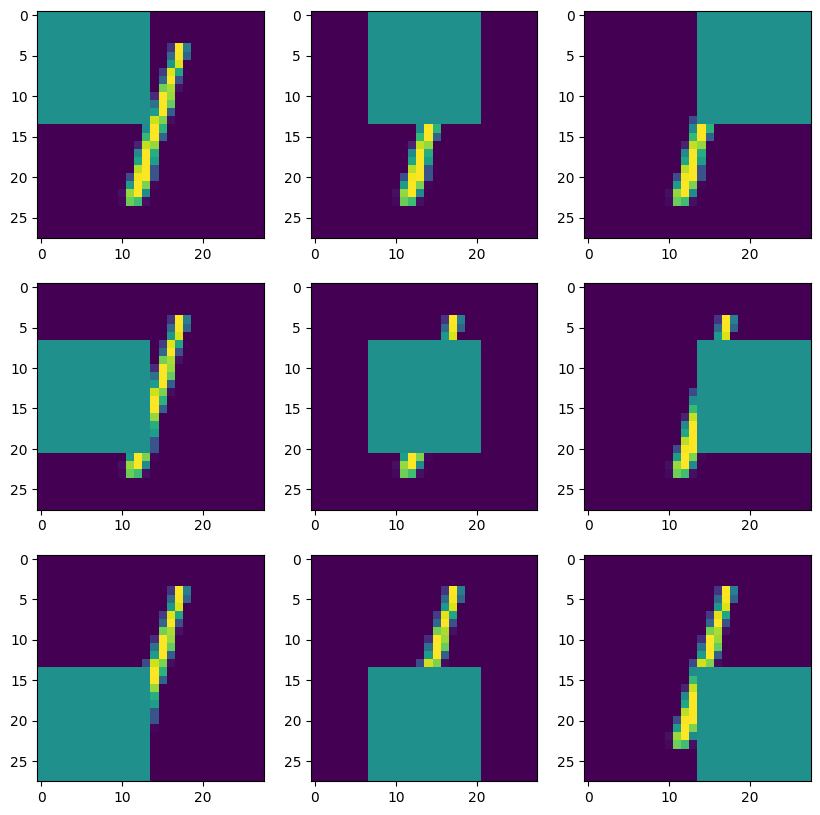

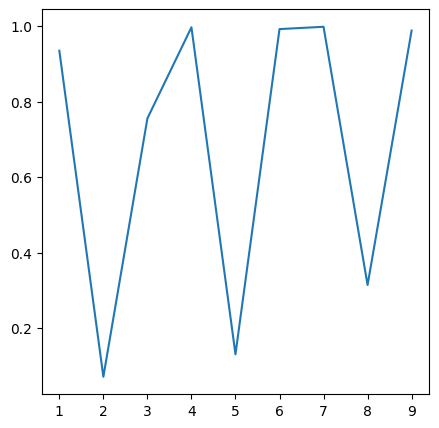

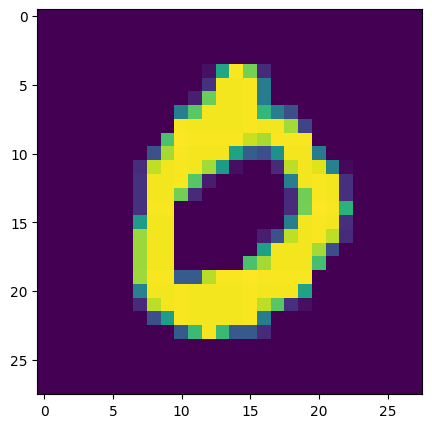

Figure:1, Actual Class:0, Probability:0.9998, Predicted:0
Figure:2, Actual Class:0, Probability:0.0388, Predicted:6
Figure:3, Actual Class:0, Probability:0.0388, Predicted:6
Figure:4, Actual Class:0, Probability:0.9964, Predicted:0
Figure:5, Actual Class:0, Probability:0.7181, Predicted:0
Figure:6, Actual Class:0, Probability:0.7989, Predicted:0
Figure:7, Actual Class:0, Probability:0.9904, Predicted:0
Figure:8, Actual Class:0, Probability:0.8281, Predicted:0
Figure:9, Actual Class:0, Probability:0.9865, Predicted:0


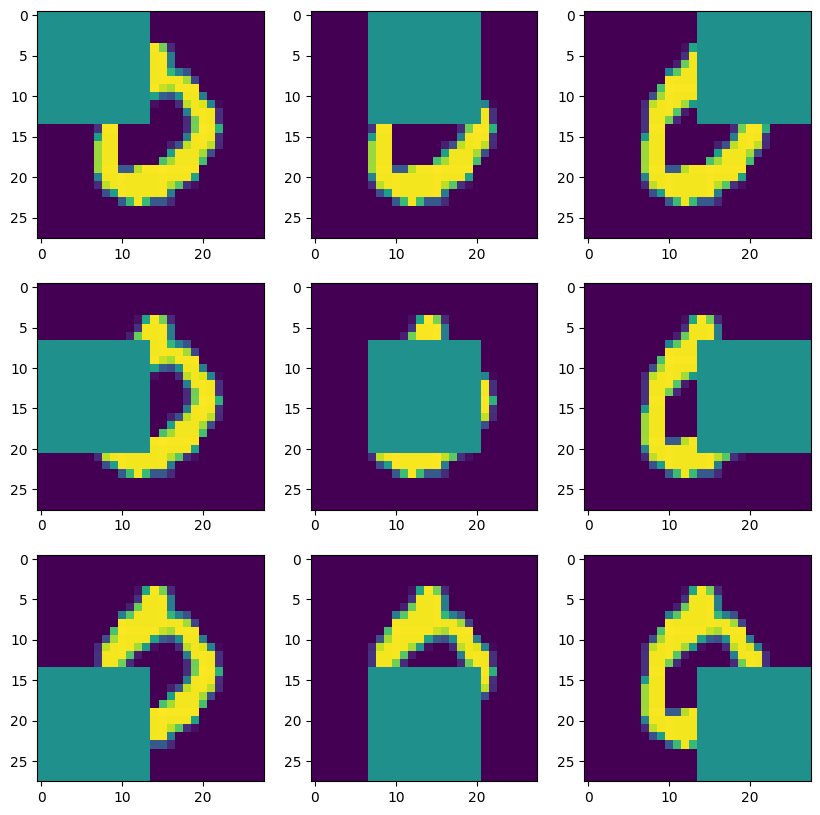

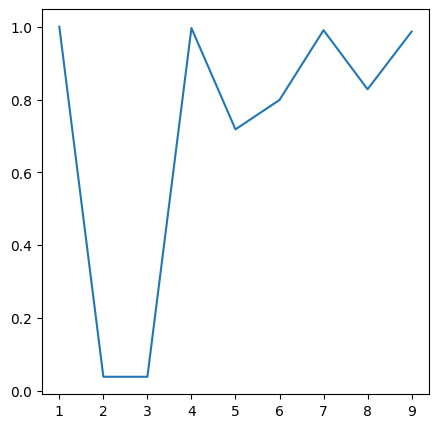

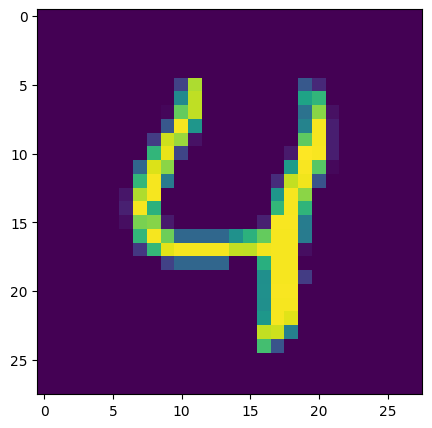

Figure:1, Actual Class:4, Probability:0.9998, Predicted:4
Figure:2, Actual Class:4, Probability:0.1515, Predicted:9
Figure:3, Actual Class:4, Probability:0.9997, Predicted:4
Figure:4, Actual Class:4, Probability:0.9985, Predicted:4
Figure:5, Actual Class:4, Probability:0.7207, Predicted:4
Figure:6, Actual Class:4, Probability:1.0000, Predicted:4
Figure:7, Actual Class:4, Probability:1.0000, Predicted:4
Figure:8, Actual Class:4, Probability:1.0000, Predicted:4
Figure:9, Actual Class:4, Probability:1.0000, Predicted:4


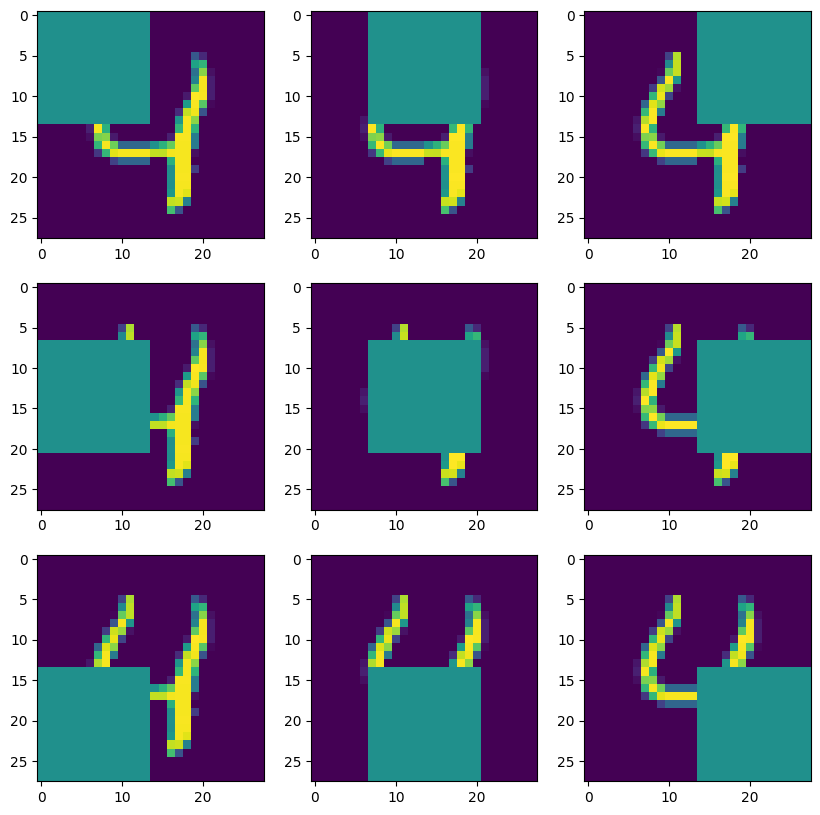

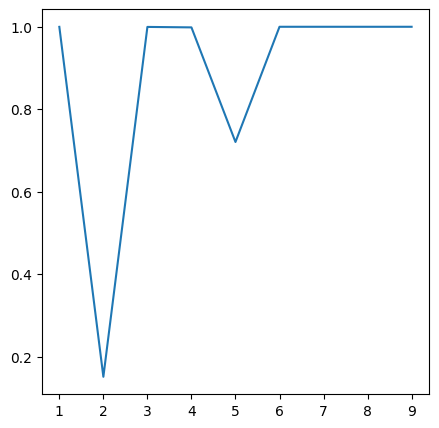

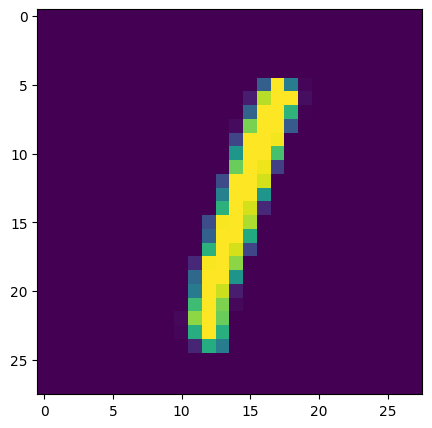

Figure:1, Actual Class:1, Probability:0.9917, Predicted:1
Figure:2, Actual Class:1, Probability:0.1457, Predicted:8
Figure:3, Actual Class:1, Probability:0.9683, Predicted:1
Figure:4, Actual Class:1, Probability:0.9997, Predicted:1
Figure:5, Actual Class:1, Probability:0.1045, Predicted:4
Figure:6, Actual Class:1, Probability:0.9987, Predicted:1
Figure:7, Actual Class:1, Probability:0.9997, Predicted:1
Figure:8, Actual Class:1, Probability:0.9180, Predicted:1
Figure:9, Actual Class:1, Probability:0.9998, Predicted:1


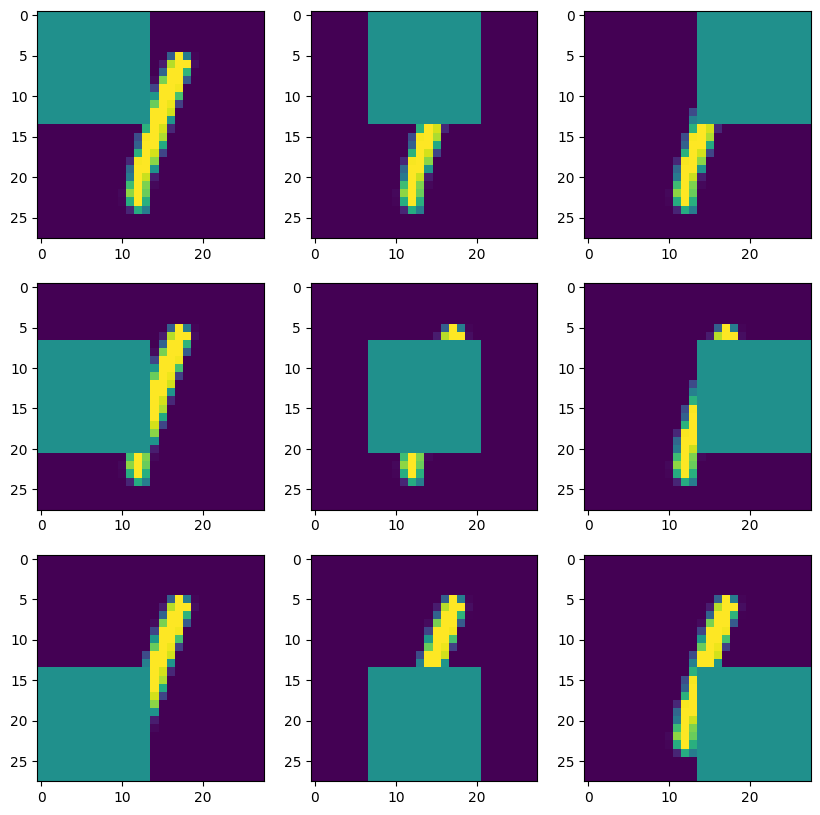

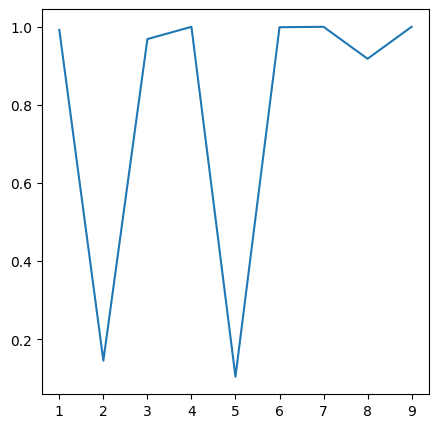

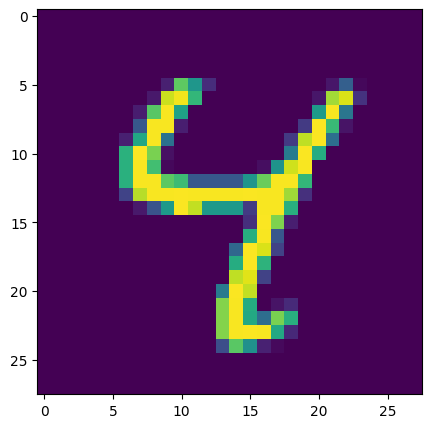

Figure:1, Actual Class:4, Probability:0.9978, Predicted:4
Figure:2, Actual Class:4, Probability:0.9507, Predicted:4
Figure:3, Actual Class:4, Probability:1.0000, Predicted:4
Figure:4, Actual Class:4, Probability:0.9762, Predicted:4
Figure:5, Actual Class:4, Probability:0.7126, Predicted:4
Figure:6, Actual Class:4, Probability:1.0000, Predicted:4
Figure:7, Actual Class:4, Probability:1.0000, Predicted:4
Figure:8, Actual Class:4, Probability:0.9985, Predicted:4
Figure:9, Actual Class:4, Probability:1.0000, Predicted:4


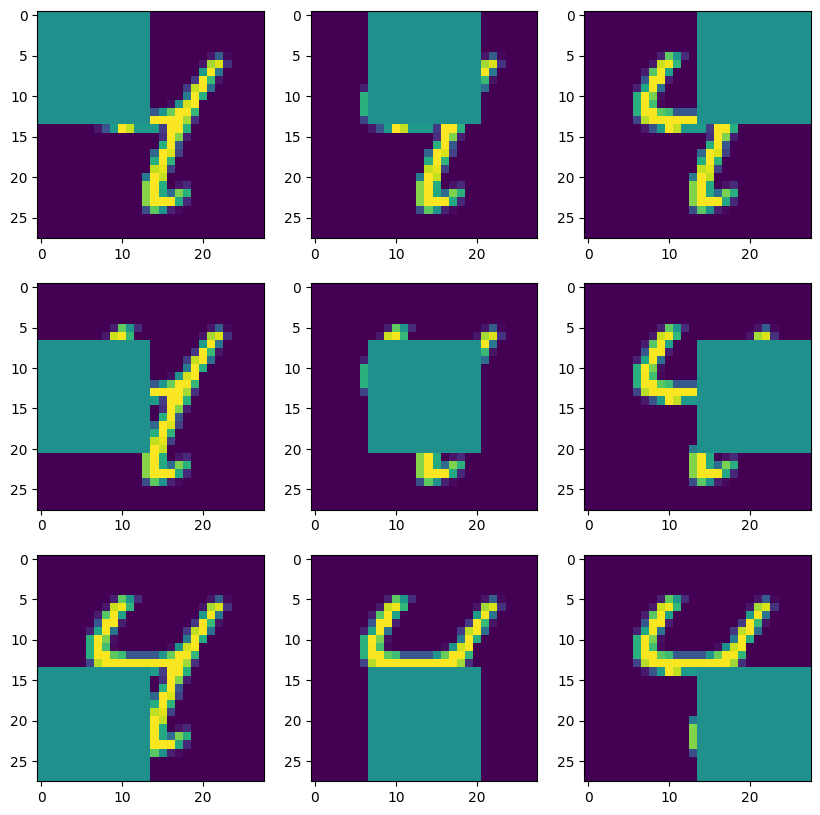

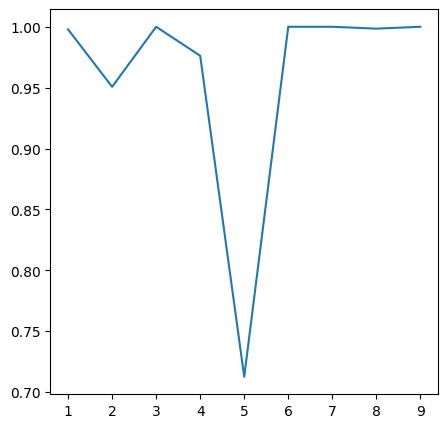

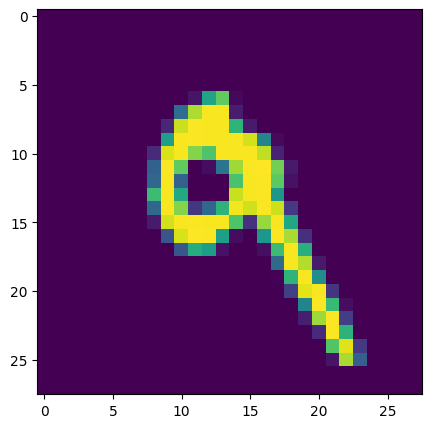

Figure:1, Actual Class:9, Probability:0.9888, Predicted:9
Figure:2, Actual Class:9, Probability:0.2927, Predicted:4
Figure:3, Actual Class:9, Probability:0.9850, Predicted:9
Figure:4, Actual Class:9, Probability:0.0308, Predicted:1
Figure:5, Actual Class:9, Probability:0.2032, Predicted:2
Figure:6, Actual Class:9, Probability:1.0000, Predicted:9
Figure:7, Actual Class:9, Probability:0.9601, Predicted:9
Figure:8, Actual Class:9, Probability:0.9690, Predicted:9
Figure:9, Actual Class:9, Probability:1.0000, Predicted:9


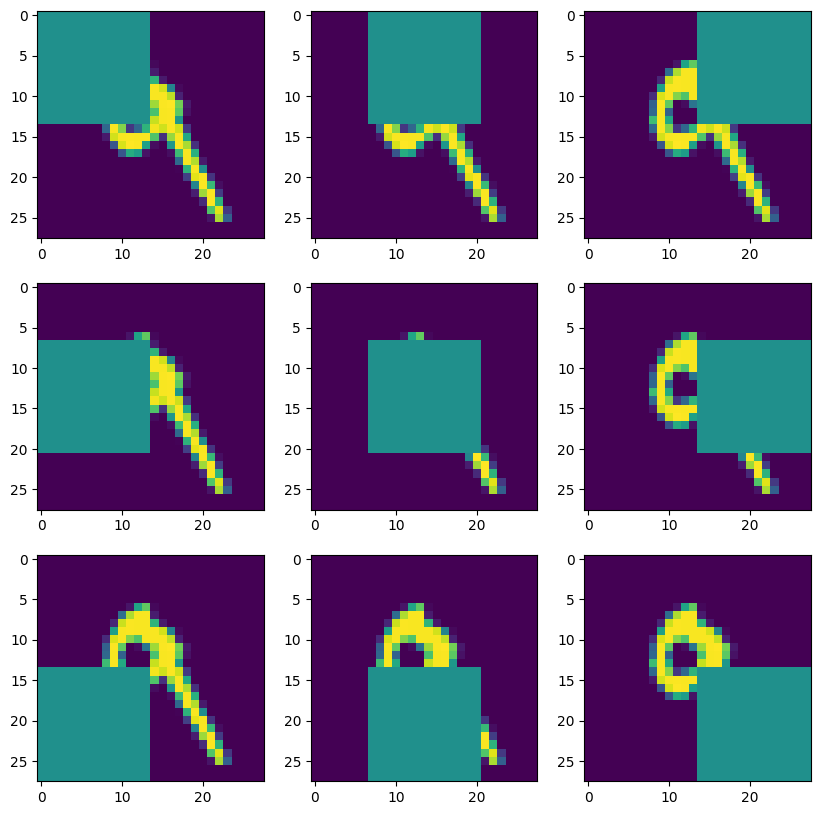

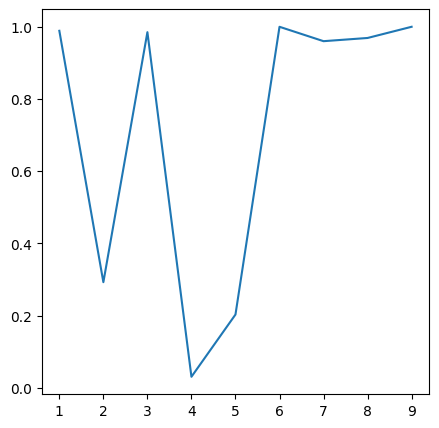

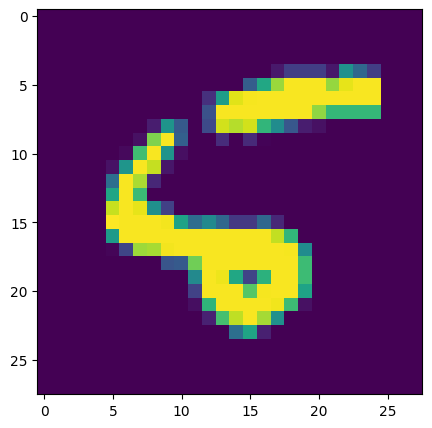

Figure:1, Actual Class:5, Probability:1.0000, Predicted:5
Figure:2, Actual Class:5, Probability:0.8597, Predicted:5
Figure:3, Actual Class:5, Probability:0.9471, Predicted:5
Figure:4, Actual Class:5, Probability:0.8823, Predicted:5
Figure:5, Actual Class:5, Probability:0.1870, Predicted:8
Figure:6, Actual Class:5, Probability:0.0082, Predicted:9
Figure:7, Actual Class:5, Probability:0.9999, Predicted:5
Figure:8, Actual Class:5, Probability:0.9955, Predicted:5
Figure:9, Actual Class:5, Probability:0.9994, Predicted:5


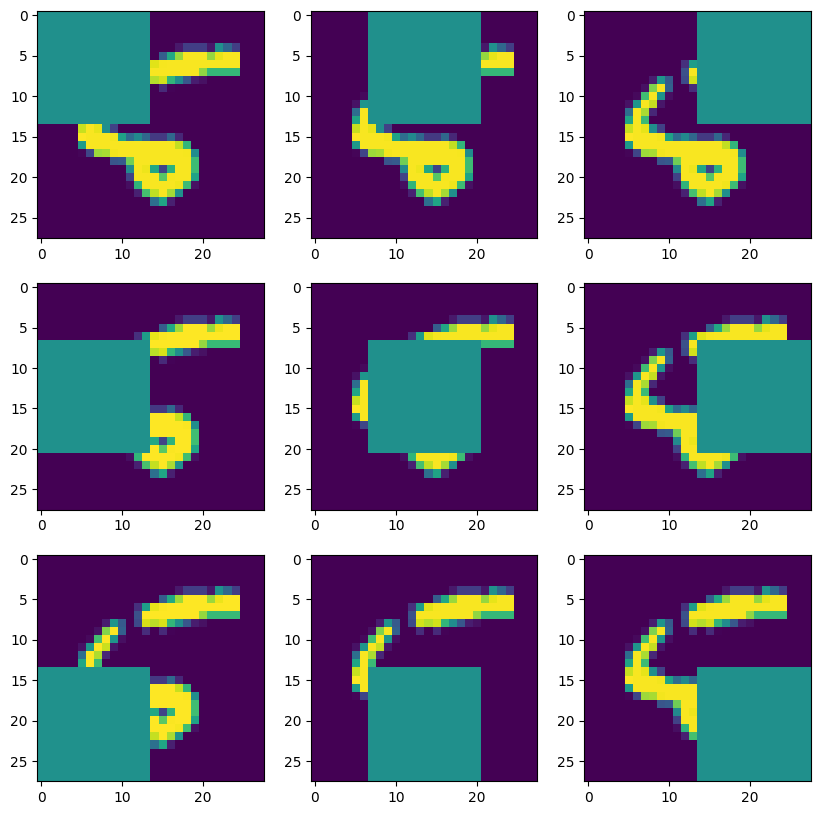

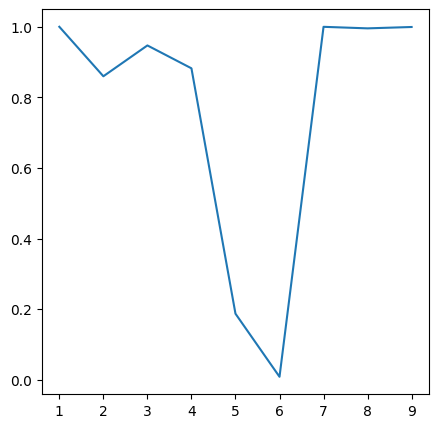

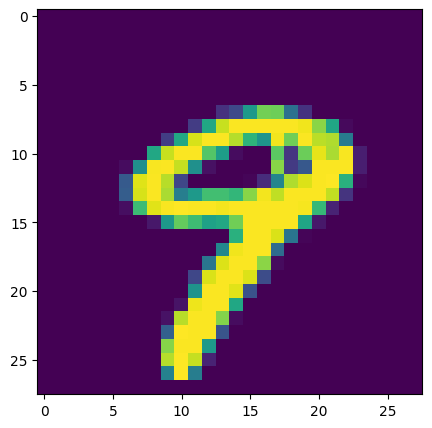

Figure:1, Actual Class:9, Probability:0.9689, Predicted:9
Figure:2, Actual Class:9, Probability:0.0012, Predicted:4
Figure:3, Actual Class:9, Probability:0.3460, Predicted:4
Figure:4, Actual Class:9, Probability:0.4030, Predicted:7
Figure:5, Actual Class:9, Probability:0.5127, Predicted:9
Figure:6, Actual Class:9, Probability:0.8052, Predicted:9
Figure:7, Actual Class:9, Probability:0.9684, Predicted:9
Figure:8, Actual Class:9, Probability:0.1119, Predicted:8
Figure:9, Actual Class:9, Probability:0.9999, Predicted:9


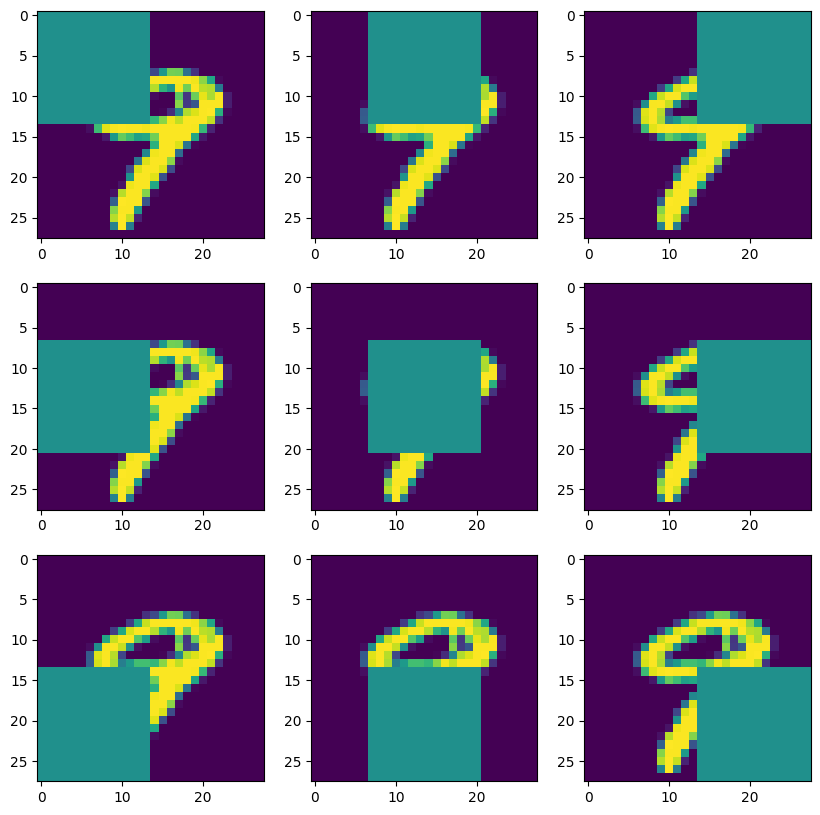

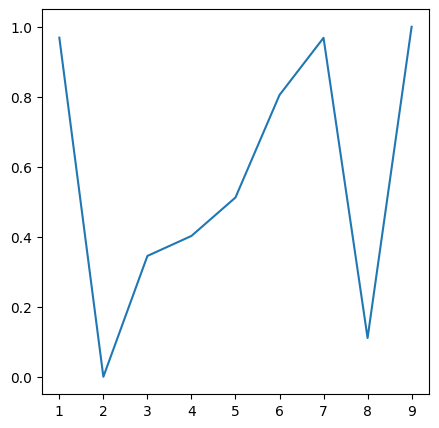

In [31]:
cnt = 0
for images,labels in visualize_loader:
  images = images.to(device)
  labels = labels.to(device)
  img = images.cpu().numpy().reshape(28,28)
  fig = plt.figure(figsize=(5,5))
  plt.imshow(img)
  plt.show()

  fig = plt.figure(figsize=(10,10))
  col,row = 3,3
  probability=[]
  for i in range(1,10):
    fig.add_subplot(row,col,i)
    oc_image = occluded_image(img,7*int((i-1)/3),7*((i-1)%3))
    plt.imshow(oc_image)
    image = torch.from_numpy(oc_image.reshape(1,1,28,28))
    image = image.to(device)
    preds = model(image)
    for ii in labels.cpu().numpy():
      idx = ii

    pred_ = preds.data.cpu().numpy()
    predicted = np.argmax(pred_)
    pred_ = np.exp(pred_)/np.sum(np.exp(pred_))
    probability.append(pred_[0,idx])
    print('Figure:{}, Actual Class:{}, Probability:{:.4f}, Predicted:{}'.format(i,idx,pred_[0,idx],predicted))
  x= np.arange(1,10,1)
  plt.figure(figsize=(5,5))
  plt.plot(x,probability,label ='probability')

  plt.show()
  cnt += 1
  if cnt == 10:
    break


##  3.1 Non-Targeted Attack

In [32]:

for child in model.children():
  for param in child.parameters():
    param.requires_grad = False

<ipython-input-33-53cee9f23b6a>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
<ipython-input-7-43bb7b7060d2>:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


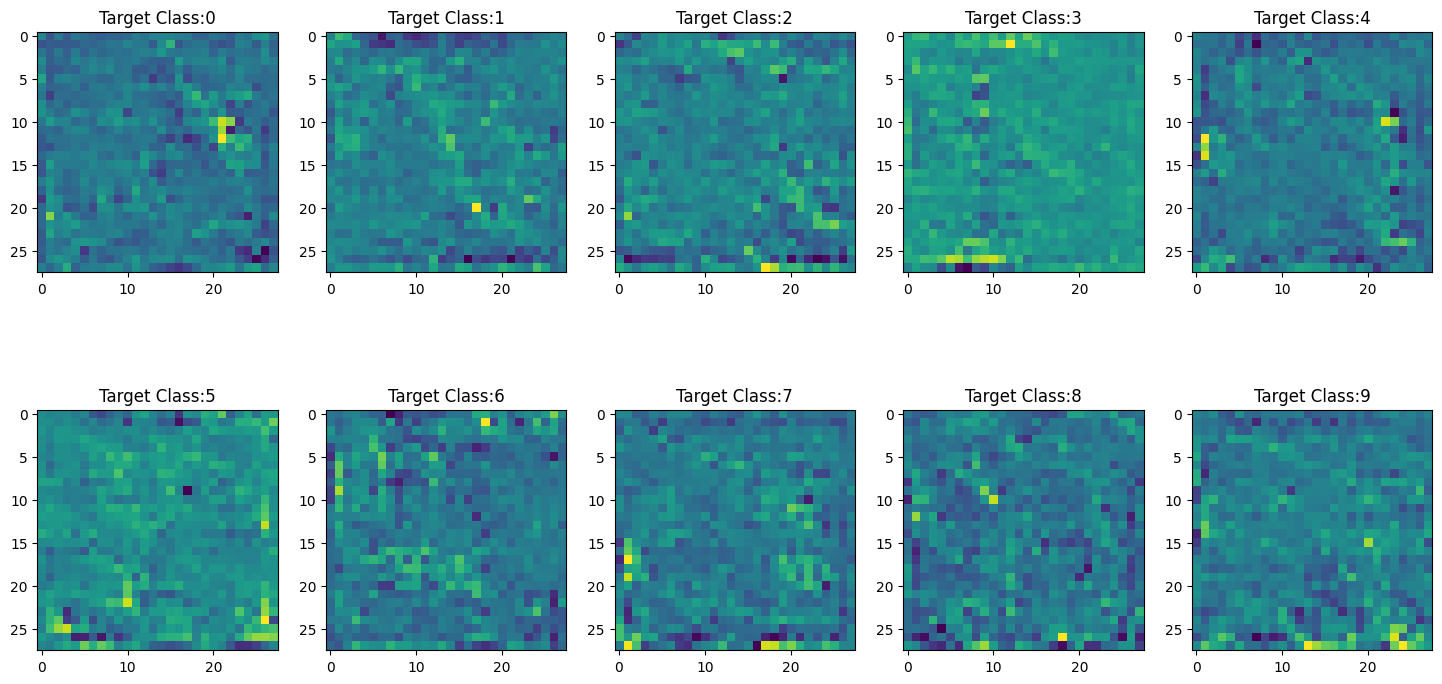

In [33]:
img_grid = np.zeros((10,28,28))
cost=[]
for i in range(10):
    image_nt = np.random.normal(loc=0.5, scale=0.05, size=(1,1,28,28)).astype(np.float32)
    image_nt = torch.from_numpy(image_nt)
    image_nt = image_nt.to(device)
    x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
    optimizer = torch.optim.SGD([x_var],lr=0.0001)
    cost=[]
    for j in range(2000):
      model.zero_grad()
      out_var = model(x_var)
      loss = -out_var[0][i]
      loss.backward()
      optimizer.step()
      cost.append(loss.item())

      # if j%500 == 0:
      #   print('Target Class:{}, Iteration:{},Cost:{}, Predicted Class:{}'.format(i,j,torch.max(out_var.data,1)[0],
                                                                                                # torch.max(out_var.data,1)[1]))
    n_img = x_var.cpu().detach().numpy()
    img_grid[i,:,:] = normalize(n_img)

fig = plt.figure(figsize=(18,9))
col,row = 5,2
for i in range(1,11):
  ax = fig.add_subplot(row,col,i)
  ax.title.set_text('Target Class:{}'.format(i-1))
  plt.imshow(img_grid[i-1])
plt.show()


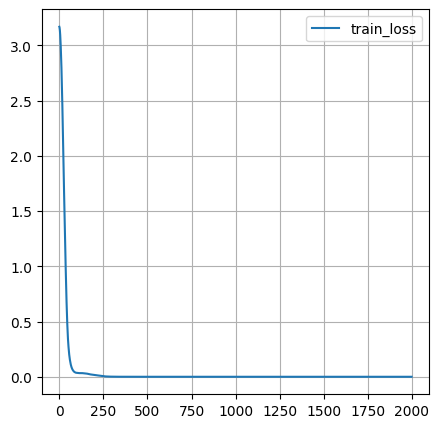

In [34]:
#cost function
x =np.arange(len(cost))
plt.figure(figsize=(5,5))
plt.plot(x,cost,label ='train_loss')
# plt.plot(x,test_cost,label='test_loss')
plt.legend()
plt.grid()
plt.show()

## 3.2 Targeted Attack

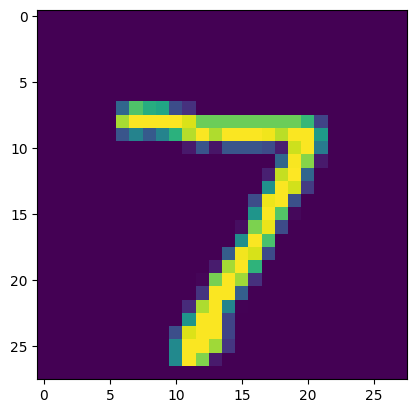

<ipython-input-47-0f45fabe5f15>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
<ipython-input-7-43bb7b7060d2>:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


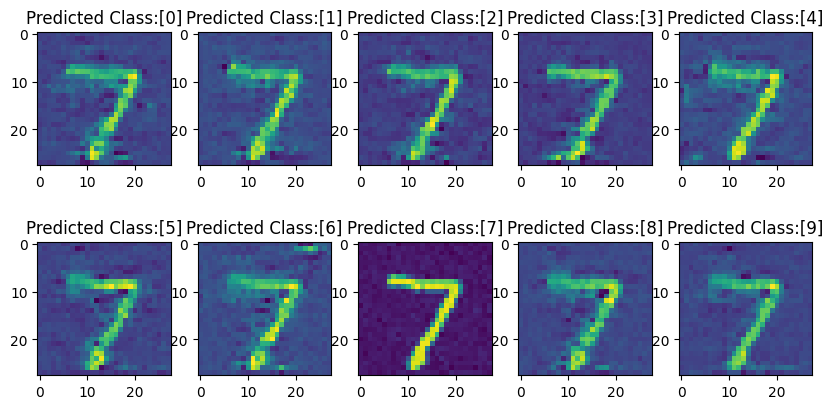

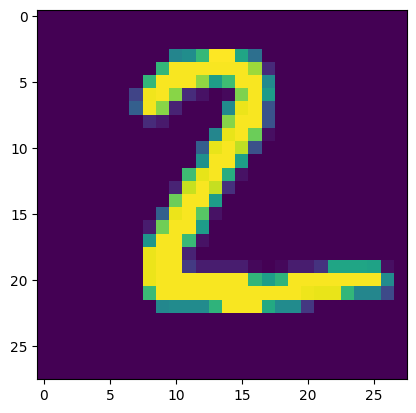

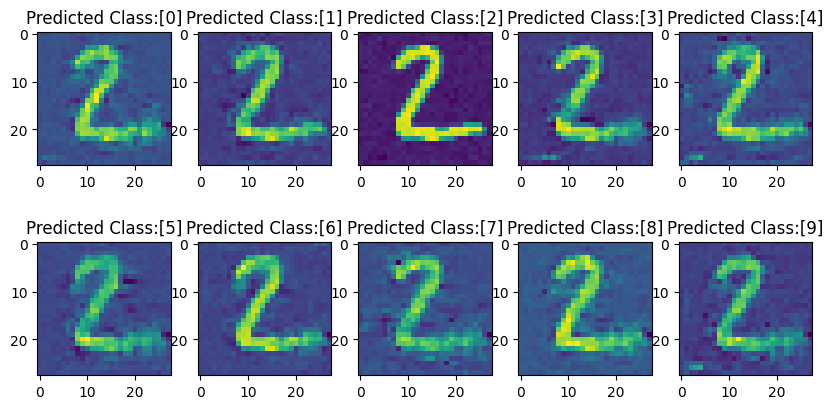

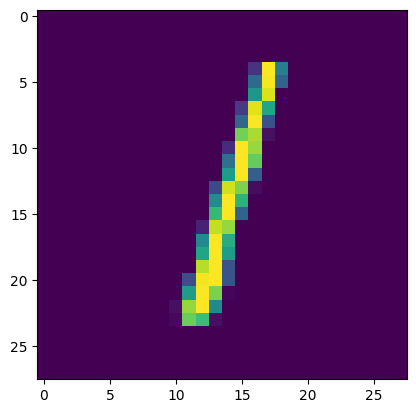

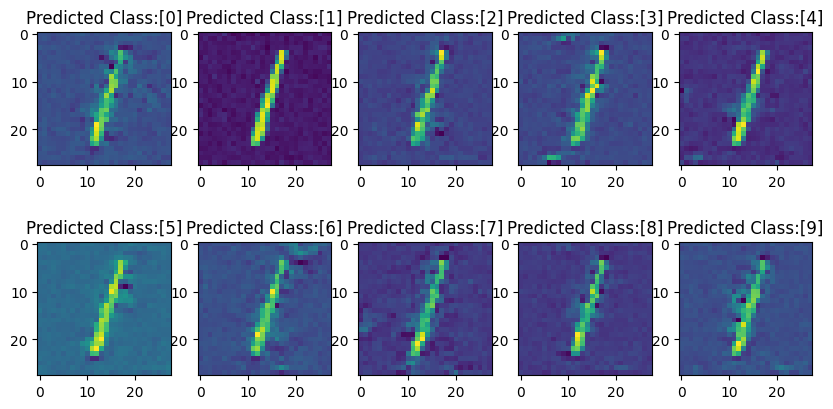

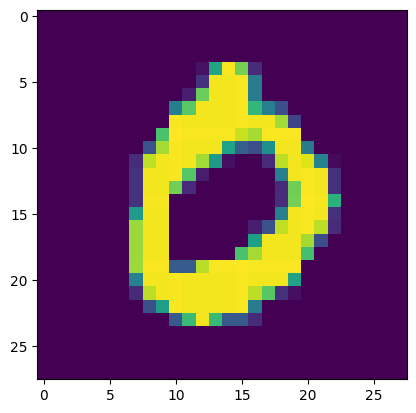

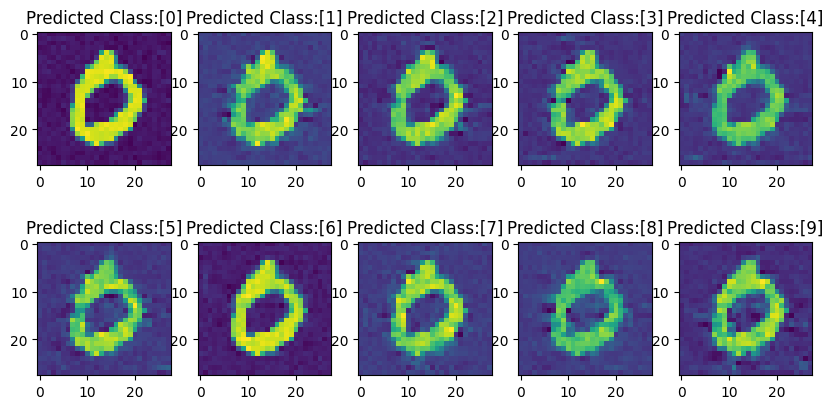

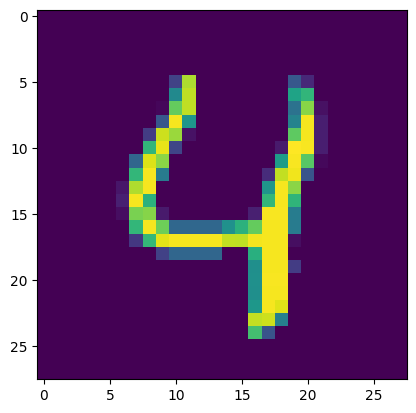

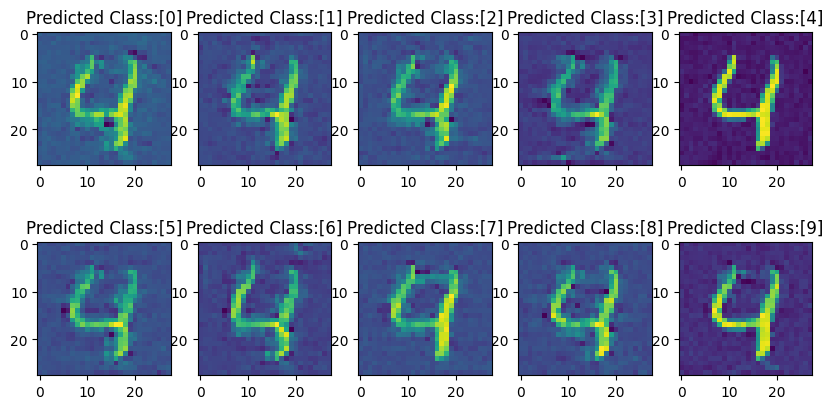

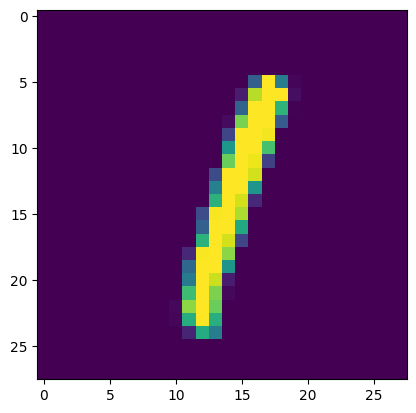

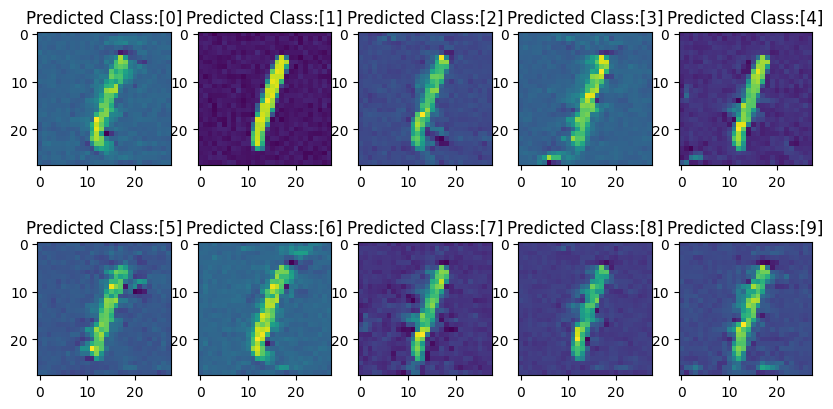

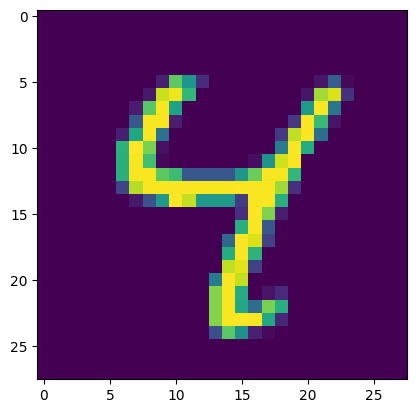

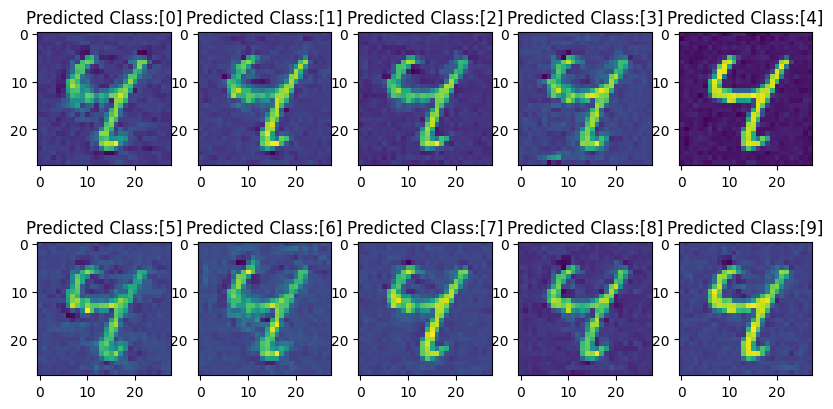

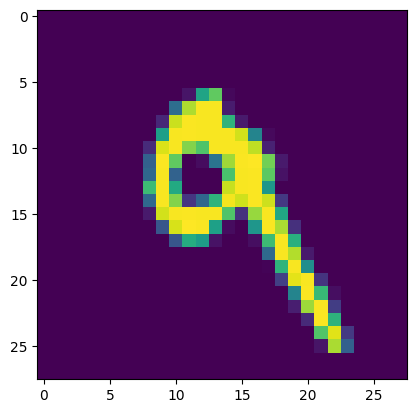

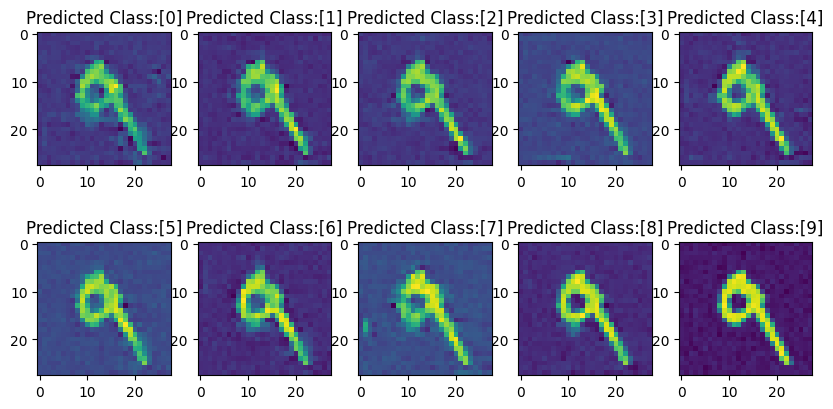

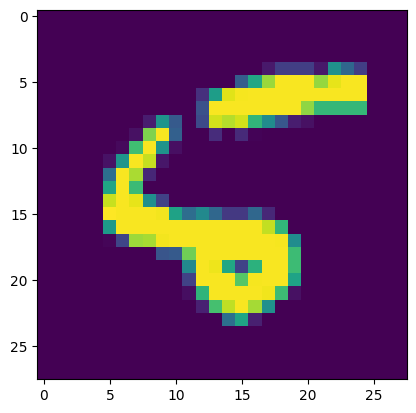

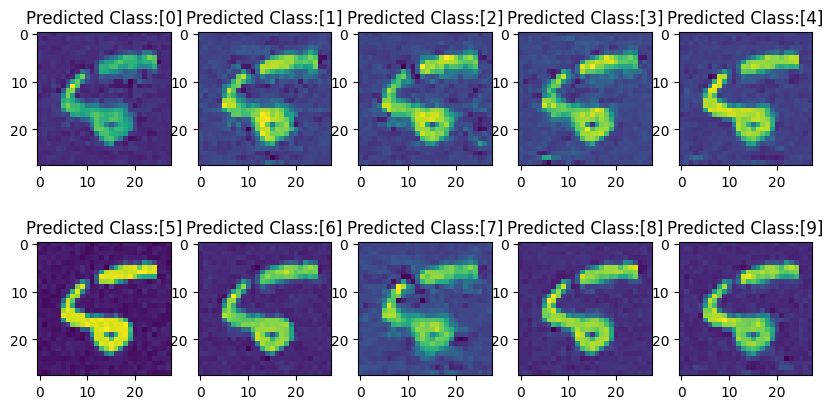

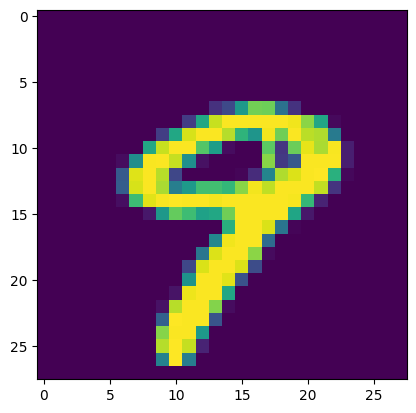

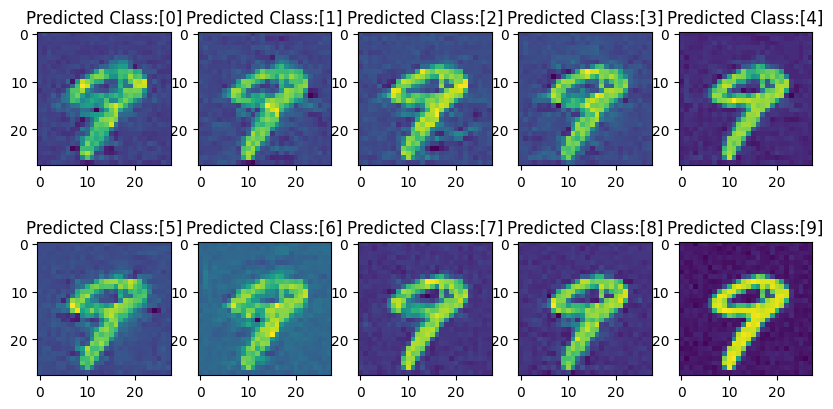

In [47]:
b = 1000
count = 0
preds = []
for img,label in visualize_loader:
  count += 1
  img = img.to(device)
  plt.imshow(img[0,0].cpu().numpy().clip(0,1))
  plt.show()
  img_grid = np.zeros((10,28,28))
  for i in range(10):
    image_nt = np.random.normal(loc=0.5, scale=0.05, size=(1,1,28,28)).astype(np.float32)
    image_nt = torch.from_numpy(image_nt)
    image_nt = image_nt.to(device)
    x_var = torch.tensor(image_nt.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
    optimizer = torch.optim.SGD([x_var],lr=0.0001)
    for j in range(200):
      model.zero_grad()
      out_var = model(x_var)
      mse_loss = nn.MSELoss()
      loss = -out_var[0][i] + b*mse_loss(x_var,img)
      loss.backward()
      optimizer.step()

      # if j%500 == 0:
      #   print('Target Class:{}, Iteration:{},Cost:{}, Predicted Class:{},Desired Class:{}'.format(i,j,torch.max(out_var.data,1)[0],
                                                                                                # torch.max(out_var.data,1)[1],label))
    n_img = x_var.cpu().detach().numpy()
    img_grid[i,:,:] = normalize(n_img)
    z = model(x_var)
    preds.append(np.argmax(z.cpu().detach().numpy(),axis=1))

  fig = plt.figure(figsize=(10,5))
  col,row = 5,2
  for i in range(1,11):
    ax = fig.add_subplot(row,col,i)
    ax.title.set_text('Predicted Class:{}'.format(preds[i-1]))
    plt.imshow(img_grid[i-1])
  plt.show()

  if count == 10:
    break